# Training and Testing Data Preparation Notebook:

In [1]:
!pip install --upgrade setuptools
!pip install tensorflow
!pip install keras

In [2]:
import sys
sys.path.append('../')

import os
import random
from functions import processing_funcs, utils
import librosa
import pandas as pd
import numpy as np
from pydub.utils import mediainfo
import math
import json
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

2022-04-18 04:22:36.499352: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-18 04:22:36.499375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Collect all the files from our processed directory:

In [3]:
voice_dir = os.path.join('..', 'voice_data')
mono_dir = 'mono_channels'
silence_dir = 'silence_removed'
mono_path = os.path.join(voice_dir, mono_dir)
sil_rmvd_dir = os.path.join(voice_dir, mono_dir, silence_dir)

voice_files = utils.read_dir_files(dir_path = sil_rmvd_dir, file_regex = r'[0-9]+\_(?:L|R)_sil_rmvd\.wav')

print('Total Files:', len(voice_files))


Total Files: 62


### Create a dictionary of features and load into a dataframe:

In [4]:
loaded_audio_dict = {}
voice_id = 0
for file_name in voice_files:
    file_path = os.path.join(sil_rmvd_dir, file_name)
    
    file_short_name = utils.get_file_name(file_name)[0:6]
    # Use [0] index to only return the array
    audio_array = librosa.load(path = file_path, sr = 8000, mono = True)[0]
    
    array_len = len(audio_array)
    
    file_duration_secs = utils.get_file_duration(file_path)
    file_duration_mins = utils.get_file_duration(file_path, minutes=True)
    
    loaded_audio_dict[file_short_name] = [audio_array,
                                          array_len,
                                          file_duration_secs,
                                          file_duration_mins,
                                          file_path,
                                          file_name,
                                          voice_id]
    voice_id = voice_id + 1

In [5]:
audio_data_df = pd.DataFrame.from_dict(data = loaded_audio_dict,
                                       orient = 'index',
                                       columns = ['time_series_array',
                                                  'array_len',
                                                  'duration (sec)',
                                                  'duration (min)',
                                                  'file_path',
                                                  'file_name',
                                                  'voice_id'])

In [6]:
audio_data_df.head()

,time_series_array,array_len,duration (sec),duration (min),file_path,file_name,voice_id
4175_L,"[-0.0005187988, -0.00048828125, -0.0004272461,...",5664256,708.032000,11.80,../voice_data/mono_channels/silence_removed/41...,4175_L_sil_rmvd.wav,0
4175_R,"[0.0010070801, 0.0015563965, 0.0019226074, 0.0...",2532352,316.544000,5.28,../voice_data/mono_channels/silence_removed/41...,4175_R_sil_rmvd.wav,1
4504_L,"[-0.0006713867, -0.0010375977, -0.0017089844, ...",1338368,167.296000,2.79,../voice_data/mono_channels/silence_removed/45...,4504_L_sil_rmvd.wav,2
4504_R,"[-3.0517578e-05, 0.0, -3.0517578e-05, 0.0, -3....",932352,116.544000,1.94,../voice_data/mono_channels/silence_removed/45...,4504_R_sil_rmvd.wav,3
4708_L,"[-0.000579834, -0.0005493164, -0.00048828125, ...",6243328,780.416000,13.01,../voice_data/mono_channels/silence_removed/47...,4708_L_sil_rmvd.wav,4


### Create directories for each of the unique voice sources for training and testing:

In [7]:
train_top_dir = os.path.join(voice_dir, 'training')
test_top_dir = os.path.join(voice_dir, 'testing')
utils.make_dir(train_top_dir)
utils.make_dir(test_top_dir)

for file_name in audio_data_df.index:
    train_file_dir = os.path.join(train_top_dir, file_name)
    test_file_dir = os.path.join(test_top_dir, file_name)
    utils.make_dir(train_file_dir)
    utils.make_dir(test_file_dir)

Creating directory at ../voice_data/training...

../voice_data/training already exists.

Creating directory at ../voice_data/testing...

../voice_data/testing already exists.

Creating directory at ../voice_data/training/4175_L...

../voice_data/training/4175_L already exists.

Creating directory at ../voice_data/testing/4175_L...

../voice_data/testing/4175_L already exists.

Creating directory at ../voice_data/training/4175_R...

../voice_data/training/4175_R already exists.

Creating directory at ../voice_data/testing/4175_R...

../voice_data/testing/4175_R already exists.

Creating directory at ../voice_data/training/4504_L...

../voice_data/training/4504_L already exists.

Creating directory at ../voice_data/testing/4504_L...

../voice_data/testing/4504_L already exists.

Creating directory at ../voice_data/training/4504_R...

../voice_data/training/4504_R already exists.

Creating directory at ../voice_data/testing/4504_R...

../voice_data/testing/4504_R already exists.

Creating

### Build a function to split audio files into smaller segments and put into individual training directories:

In [8]:
# Code based on: https://stackoverflow.com/questions/37999150/how-to-split-a-wav-file-into-multiple-wav-files

class SplitWavAudio():
    def __init__(self, folder, filename, save_folder):
        self.folder = folder
        self.filename = filename
        self.short_filename = filename[0:6]
        self.filepath = os.path.join(folder, filename)
        self.save_folder = save_folder
        
        self.audio = AudioSegment.from_wav(self.filepath)
    
    def get_duration(self):
        return self.audio.duration_seconds
    
    def single_split(self, from_sec, to_sec, split_filename):
        t1 = from_sec * 1000
        t2 = to_sec * 1000
        split_audio = self.audio[t1:t2]
        splt_aud_sav_nm = os.path.join(self.save_folder, split_filename)
        split_audio.export(splt_aud_sav_nm, format="wav")
        
    def multiple_split(self, sec_per_split, verbose=False):
        total_secs = math.ceil(self.get_duration())
        for i in range(0, total_secs, sec_per_split):
            if sec_per_split > total_secs - i:
                break
            split_fn = self.short_filename + '_' + str(i) + '.wav'
            self.single_split(i, i + sec_per_split, split_fn)
            if verbose == True:
                print(str(i) + ' Done')
            if i == total_secs - sec_per_split:
                print('All split successfully')

In [9]:
# Just for testing purposes, delete everything in training and testing files:

def clear_train_test_dirs():
    
    training_dirs = os.listdir(train_top_dir)
    testing_dirs = os.listdir(test_top_dir)
    
    for train_dir in training_dirs:
        utils.del_dir_files(dir_path=os.path.join(train_top_dir, train_dir), check=False, verbose=False)
        
    for testing_dir in testing_dirs:
        utils.del_dir_files(dir_path=os.path.join(test_top_dir, testing_dir), check=False, verbose=False)
        
# clear_train_test_dirs()

In [10]:
%%time

# Split the files into segments of 5 seconds in length and move into their respective training directory:
for file in audio_data_df.file_name:
    save_path = os.path.join(train_top_dir, file[0:6])
    aud_split = SplitWavAudio(sil_rmvd_dir, filename = file, save_folder = save_path)
    aud_split.multiple_split(120)

CPU times: user 112 ms, sys: 200 ms, total: 312 ms
Wall time: 313 ms


### Randomly move 15% of each of the files to the testing directory:

In [11]:
# Set random seed:
random.seed(8675309)

# Based on code here: https://stackoverflow.com/questions/59952200/move-a-random-sample-of-files-from-one-folder-to-another

def move_data(source_dir, dest_dir, perc_move=0.15, verbose=True):
    
    source_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    num_source_files = len(source_files)
    num_files_to_move = math.floor(num_source_files * float(perc_move))
    
    if verbose:
        print(f'Number of files in {source_dir} = {num_source_files}.')
        print(f'Randomly moving {perc_move}% ({num_files_to_move}) of files from {source_dir} to {dest_dir}.')
        
    for i in range(num_files_to_move):
        # Choose a file randomly from the source directory:
        random_file = random.choice(os.listdir(source_dir))
        
        # Get path of the randomly-chosen file:
        source_file = os.path.join(source_dir, random_file)
        
        # Create filepath for the destination:
        dest_file = os.path.join(dest_dir, random_file)
        
        os.replace(source_file, dest_file)
        
    print(f'{num_files_to_move} files moved from {source_dir} to {dest_dir}.')

In [12]:
train_dirs = utils.read_dir_files(dir_path = train_top_dir, file_regex=r'[0-9]+_(L|R)')

for train_dir in train_dirs:
    
    train_file = os.path.join(train_top_dir, train_dir)
    test_file = os.path.join(test_top_dir, train_dir)
    
    move_data(train_file, test_file)


Number of files in ../voice_data/training/4175_L = 5.
Randomly moving 0.15% (0) of files from ../voice_data/training/4175_L to ../voice_data/testing/4175_L.
0 files moved from ../voice_data/training/4175_L to ../voice_data/testing/4175_L.
Number of files in ../voice_data/training/4175_R = 2.
Randomly moving 0.15% (0) of files from ../voice_data/training/4175_R to ../voice_data/testing/4175_R.
0 files moved from ../voice_data/training/4175_R to ../voice_data/testing/4175_R.
Number of files in ../voice_data/training/4504_L = 1.
Randomly moving 0.15% (0) of files from ../voice_data/training/4504_L to ../voice_data/testing/4504_L.
0 files moved from ../voice_data/training/4504_L to ../voice_data/testing/4504_L.
Number of files in ../voice_data/training/4504_R = 0.
Randomly moving 0.15% (0) of files from ../voice_data/training/4504_R to ../voice_data/testing/4504_R.
0 files moved from ../voice_data/training/4504_R to ../voice_data/testing/4504_R.
Number of files in ../voice_data/training/4

### Create training and testing dataframes with file_path to each audio file and class label:

In [13]:
audio_data_df.head(5)

,time_series_array,array_len,duration (sec),duration (min),file_path,file_name,voice_id
4175_L,"[-0.0005187988, -0.00048828125, -0.0004272461,...",5664256,708.032000,11.80,../voice_data/mono_channels/silence_removed/41...,4175_L_sil_rmvd.wav,0
4175_R,"[0.0010070801, 0.0015563965, 0.0019226074, 0.0...",2532352,316.544000,5.28,../voice_data/mono_channels/silence_removed/41...,4175_R_sil_rmvd.wav,1
4504_L,"[-0.0006713867, -0.0010375977, -0.0017089844, ...",1338368,167.296000,2.79,../voice_data/mono_channels/silence_removed/45...,4504_L_sil_rmvd.wav,2
4504_R,"[-3.0517578e-05, 0.0, -3.0517578e-05, 0.0, -3....",932352,116.544000,1.94,../voice_data/mono_channels/silence_removed/45...,4504_R_sil_rmvd.wav,3
4708_L,"[-0.000579834, -0.0005493164, -0.00048828125, ...",6243328,780.416000,13.01,../voice_data/mono_channels/silence_removed/47...,4708_L_sil_rmvd.wav,4


In [14]:
train_dirs = utils.read_dir_files(dir_path = train_top_dir, file_regex=r'[0-9]+_(L|R)')
test_dirs = utils.read_dir_files(dir_path = test_top_dir, file_regex=r'[0-9]+_(L|R)')

training_df_dict = {}
testing_df_dict = {}

train_index = 0
test_index = 0

for train_dir in train_dirs:
    dir_path = os.path.join(train_top_dir, train_dir)
    files = utils.read_dir_files(dir_path, file_regex=None)
    
    for file in files:
        file_path = os.path.join(dir_path, file)
        voice_id = audio_data_df.loc[train_dir].voice_id
        
        training_df_dict[train_index] = [file_path, voice_id]
        
        train_index = train_index + 1
        
for test_dir in test_dirs:
    dir_path = os.path.join(test_top_dir, test_dir)
    files = utils.read_dir_files(dir_path, file_regex=None)
    
    for file in files:
        file_path = os.path.join(dir_path, file)
        voice_id = audio_data_df.loc[test_dir].voice_id
        
        testing_df_dict[test_index] = [file_path, voice_id]
        
        test_index = test_index + 1

In [15]:
training_data_df = pd.DataFrame.from_dict(data = training_df_dict,
                                          orient = 'index',
                                          columns = ['file_path', 'voice_id'])

testing_data_df = pd.DataFrame.from_dict(data = testing_df_dict,
                                         orient = 'index',
                                         columns = ['file_path', 'voice_id'])

In [16]:
training_data_df.head()

,file_path,voice_id
0,../voice_data/training/4175_L/4175_L_0.wav,0
1,../voice_data/training/4175_L/4175_L_120.wav,0
2,../voice_data/training/4175_L/4175_L_240.wav,0
3,../voice_data/training/4175_L/4175_L_360.wav,0
4,../voice_data/training/4175_L/4175_L_480.wav,0


In [17]:
testing_data_df.head()

,file_path,voice_id
0,../voice_data/testing/6015_R/6015_R_360.wav,27
1,../voice_data/testing/6062_R/6062_R_120.wav,29
2,../voice_data/testing/6126_L/6126_L_480.wav,34


In [18]:
training_data_df.to_csv(os.path.join('..', 'meta_data', 'training_files.csv'))

In [19]:
testing_data_df.to_csv(os.path.join('..', 'meta_data', 'testing_files.csv'))

In [20]:
%%time
training_dict = {}
index = 0
for file in training_data_df['file_path']:
    # Use [0] index to only return the array
    audio, sr = librosa.load(path = file_path, sr = None, mono = True)
    mfccs = librosa.feature.mfcc(audio, n_mfcc=13, sr=sr)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    comp_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    voice_id = training_data_df.loc[index].voice_id
    
    training_dict[index] = [file,
                            comp_mfccs,
                            voice_id]
    index = index + 1

<timed exec>:6: FutureWarning: Pass y=[-6.1035156e-05 -3.0517578e-05  0.0000000e+00 ... -6.9885254e-03
 -4.2724609e-03  4.0893555e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error


CPU times: user 1min 9s, sys: 1min 11s, total: 2min 21s
Wall time: 20.1 s


In [21]:
len(training_dict.get(0)[1])
training_dict.get(0)[1]

array([[-5.7350281e+02, -4.1267941e+02, -3.8075653e+02, ...,
        -2.5894394e+02, -2.8466058e+02, -3.5062991e+02],
       [-1.9586767e+01, -2.7931358e+01, -1.8973734e+01, ...,
         9.9075067e-01,  5.5522980e+01,  7.9878845e+01],
       [-3.4327576e+01, -6.2844822e+01, -6.1083496e+01, ...,
         1.6383835e+01, -8.3743622e+01, -1.1932994e+02],
       ...,
       [-8.1890649e-01, -8.1890649e-01, -8.1890649e-01, ...,
        -8.0307424e-01, -8.0307424e-01, -8.0307424e-01],
       [ 3.6209166e-01,  3.6209166e-01,  3.6209166e-01, ...,
         1.0937040e+00,  1.0937040e+00,  1.0937040e+00],
       [ 1.4609379e+00,  1.4609379e+00,  1.4609379e+00, ...,
        -1.8774568e-01, -1.8774568e-01, -1.8774568e-01]], dtype=float32)

In [22]:
%%time
testing_dict = {}
index = 0
for file in testing_data_df['file_path']:
    # Use [0] index to only return the array
    audio, sr = librosa.load(path = file_path, sr = None, mono = True)
    mfccs = librosa.feature.mfcc(audio, n_mfcc=13, sr=sr)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    comp_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    voice_id = training_data_df.loc[index].voice_id
    
    testing_dict[index] = [file,
                            comp_mfccs,
                            voice_id]
    index = index + 1

<timed exec>:6: FutureWarning: Pass y=[-6.1035156e-05 -3.0517578e-05  0.0000000e+00 ... -6.9885254e-03
 -4.2724609e-03  4.0893555e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error


CPU times: user 922 ms, sys: 886 ms, total: 1.81 s
Wall time: 288 ms


In [23]:
def save_comrehensive_mfccs(audio_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, segment_dur=5):
    # Need a dictionary to store the data
    data = {
        "mapping": [],
        "mfccs": [],
        "labels": []
    }
    
    # Loop through audio path
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(audio_path)):
        # Ensure not at root level
        print(dirpath, audio_path)
        if dirpath is not audio_path:
            # Save the label
            dirpath_components = dirpath.split("/")
            speaker_channel = dirpath_components[-1]
            # print(dirpath, speaker_channel)
            data["mapping"].append(speaker_channel)
            # Process files for speaker channel
            for f in filenames:
                # Load audio
                fp = os.path.join(dirpath, f)
                signal, sr = librosa.load(fp, sr=None)
                duration = librosa.get_duration(signal)
                samples_per_track = sr * duration
                num_segments = int(duration/segment_dur)
                num_samples_per_segment = int(samples_per_track/num_segments)
                print("number of samples per segment are ", num_samples_per_segment)
                expected_num_mfcc_per_segment = math.ceil(num_samples_per_segment/hop_length)
                
                # Process segments extracting mfcc, delta mfcc, and delta2 mfcc. Then store the data
                for s in range(num_segments):
                    start_sample = num_samples_per_segment * s
                    end_sample = start_sample + num_samples_per_segment
                    print(f"start {start_sample} end {end_sample}")
                    mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
                    # delta_mfccs = librosa.feature.delta(mfccs)
                    # delta2_mfccs = librosa.feature.delta(mfccs, order=2)
                    # comp_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
                    # comp_mfccs = comp_mfccs.T
                    mfccs = mfccs.T
                    
                    if len(mfccs) == expected_num_mfcc_per_segment:
                        print("joining data")
                        data["mfccs"].append(mfccs.tolist())
                        data["labels"].append(i-1)
                        print("{} segment: {} label: {}".format(fp, s, i-1))
    
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [24]:
%%time
train_test_json = os.path.join('..', 'meta_data', 'full_dataset')
# Using mono_path since this was splitting data of already split data. 
save_comrehensive_mfccs(train_top_dir, train_test_json, segment_dur=10)

../voice_data/training ../voice_data/training
../voice_data/training/4175_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4175_L/4175_L_0.wav segment: 0 label: 0
start 87074 end 174148
joining data
../voice_data/training/4175_L/4175_L_0.wav segment: 1 label: 0
start 174148 end 261222
joining data
../voice_data/training/4175_L/4175_L_0.wav segment: 2 label: 0
start 261222 end 348296
joining data
../voice_data/training/4175_L/4175_L_0.wav segment: 3 label: 0
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4175_L/4175_L_120.wav segment: 0 label: 0
start 87074 end 174148
joining data
../voice_data/training/4175_L/4175_L_120.wav segment: 1 label: 0
start 174148 end 261222
joining data
../voice_data/training/4175_L/4175_L_120.wav segment: 2 label: 0
start 261222 end 348296
joining data
../voice_data/training/4175_L/4175_L_120.wav segment: 3 label: 0
number of samples per seg

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.0005188  -0.00048828 -0.00042725 ... -0.00030518 -0.00027466
 -0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.0005188  -0.00048828 -0.00042725 ... -0.00772095 -0.01397705
 -0.01391602] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.01132202 -0.00891113 -0.00656128 ... -0.03851318 -0.04910278
  0.02301025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/i

joining data
../voice_data/training/4175_L/4175_L_240.wav segment: 2 label: 0
start 261222 end 348296
joining data
../voice_data/training/4175_L/4175_L_240.wav segment: 3 label: 0
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4175_L/4175_L_360.wav segment: 0 label: 0
start 87074 end 174148
joining data
../voice_data/training/4175_L/4175_L_360.wav segment: 1 label: 0
start 174148 end 261222
joining data
../voice_data/training/4175_L/4175_L_360.wav segment: 2 label: 0
start 261222 end 348296
joining data
../voice_data/training/4175_L/4175_L_360.wav segment: 3 label: 0
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4175_L/4175_L_480.wav segment: 0 label: 0
start 87074 end 174148
joining data
../voice_data/training/4175_L/4175_L_480.wav segment: 1 label: 0
start 174148 end 261222
joining data
../voice_data/training/4175_L/4175_L_480.wav segment: 2 label: 0
start 261222 end 348296
joining data
.

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.14559937 -0.11633301 -0.08782959 ...  0.00137329  0.00222778
  0.00308228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.14559937 -0.11633301 -0.08782959 ...  0.03451538 -0.01071167
 -0.03030396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.02639771 -0.0234375   0.03842163 ... -0.03933716 -0.03805542
  0.0027771 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/i

joining data
../voice_data/training/4175_R/4175_R_0.wav segment: 1 label: 1
start 174148 end 261222
joining data
../voice_data/training/4175_R/4175_R_0.wav segment: 2 label: 1
start 261222 end 348296
joining data
../voice_data/training/4175_R/4175_R_0.wav segment: 3 label: 1
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4175_R/4175_R_120.wav segment: 0 label: 1
start 87074 end 174148
joining data
../voice_data/training/4175_R/4175_R_120.wav segment: 1 label: 1
start 174148 end 261222
joining data
../voice_data/training/4175_R/4175_R_120.wav segment: 2 label: 1
start 261222 end 348296
joining data
../voice_data/training/4175_R/4175_R_120.wav segment: 3 label: 1
../voice_data/training/4504_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4504_L/4504_L_0.wav segment: 0 label: 2
start 87074 end 174148
joining data
../voice_data/training/4504_L/4504_L_0.wav segment: 1 labe

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00366211  0.00265503  0.00234985 ... -0.00442505 -0.00604248
 -0.003479  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00775146 -0.0218811  -0.00970459 ... -0.00317383  0.00485229
  0.01071167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00775146 -0.0218811  -0.00970459 ...  0.00299072 -0.00341797
 -0.00894165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/i

joining data
../voice_data/training/4504_L/4504_L_0.wav segment: 3 label: 2
../voice_data/training/4504_R ../voice_data/training
../voice_data/training/4708_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4708_L/4708_L_0.wav segment: 0 label: 4
start 87074 end 174148
joining data
../voice_data/training/4708_L/4708_L_0.wav segment: 1 label: 4
start 174148 end 261222
joining data
../voice_data/training/4708_L/4708_L_0.wav segment: 2 label: 4
start 261222 end 348296
joining data
../voice_data/training/4708_L/4708_L_0.wav segment: 3 label: 4
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4708_L/4708_L_120.wav segment: 0 label: 4
start 87074 end 174148
joining data
../voice_data/training/4708_L/4708_L_120.wav segment: 1 label: 4
start 174148 end 261222
joining data
../voice_data/training/4708_L/4708_L_120.wav segment: 2 label: 4
start 261222 end 348296
joining data
../voic

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00112915  0.00170898  0.00067139 ... -0.00314331 -0.00244141
 -0.00195312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-1.4648438e-03 -5.7983398e-04  3.0517578e-05 ...  8.4228516e-03
 -1.9226074e-03 -1.6174316e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-3.6346436e-02 -4.2510986e-02 -2.2186279e-02 ...  0.0000000e+00
  3.0517578e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration =

joining data
../voice_data/training/4708_L/4708_L_240.wav segment: 1 label: 4
start 174148 end 261222
joining data
../voice_data/training/4708_L/4708_L_240.wav segment: 2 label: 4
start 261222 end 348296
joining data
../voice_data/training/4708_L/4708_L_240.wav segment: 3 label: 4
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4708_L/4708_L_360.wav segment: 0 label: 4
start 87074 end 174148
joining data
../voice_data/training/4708_L/4708_L_360.wav segment: 1 label: 4
start 174148 end 261222
joining data
../voice_data/training/4708_L/4708_L_360.wav segment: 2 label: 4
start 261222 end 348296
joining data
../voice_data/training/4708_L/4708_L_360.wav segment: 3 label: 4
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4708_L/4708_L_480.wav segment: 0 label: 4
start 87074 end 174148
joining data
../voice_data/training/4708_L/4708_L_480.wav segment: 1 label: 4
start 174148 end 261222
joining data
.

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 0.00158691  0.00366211  0.00149536 ... -0.00115967 -0.0012207
 -0.00088501] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00158691  0.00366211  0.00149536 ... -0.01434326  0.01443481
  0.00595093] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.01153564  0.00030518  0.00366211 ... -0.06161499 -0.04296875
  0.00604248] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ip

number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4708_L/4708_L_600.wav segment: 0 label: 4
start 87074 end 174148
joining data
../voice_data/training/4708_L/4708_L_600.wav segment: 1 label: 4
start 174148 end 261222
joining data
../voice_data/training/4708_L/4708_L_600.wav segment: 2 label: 4
start 261222 end 348296
joining data
../voice_data/training/4708_L/4708_L_600.wav segment: 3 label: 4
../voice_data/training/4708_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4708_R/4708_R_0.wav segment: 0 label: 5
start 87074 end 174148
joining data
../voice_data/training/4708_R/4708_R_0.wav segment: 1 label: 5
start 174148 end 261222
joining data
../voice_data/training/4708_R/4708_R_0.wav segment: 2 label: 5
start 261222 end 348296
joining data
../voice_data/training/4708_R/4708_R_0.wav segment: 3 label: 5
number of samples per segment are  87074
start 0 end 87074
joining data

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00479126  0.01757812  0.01043701 ... -0.00021362 -0.00061035
 -0.00079346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-1.2207031e-04 -3.0517578e-05 -6.1035156e-05 ... -3.3569336e-04
  1.5258789e-04  1.2207031e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-1.2207031e-04 -3.0517578e-05 -6.1035156e-05 ... -2.4414062e-04
 -3.6621094e-04 -9.1552734e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n

joining data
../voice_data/training/4708_R/4708_R_120.wav segment: 1 label: 5
start 174148 end 261222
joining data
../voice_data/training/4708_R/4708_R_120.wav segment: 2 label: 5
start 261222 end 348296
joining data
../voice_data/training/4708_R/4708_R_120.wav segment: 3 label: 5
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4708_R/4708_R_240.wav segment: 0 label: 5
start 87074 end 174148
joining data
../voice_data/training/4708_R/4708_R_240.wav segment: 1 label: 5
start 174148 end 261222
joining data
../voice_data/training/4708_R/4708_R_240.wav segment: 2 label: 5
start 261222 end 348296
joining data
../voice_data/training/4708_R/4708_R_240.wav segment: 3 label: 5
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4708_R/4708_R_360.wav segment: 0 label: 5
start 87074 end 174148
joining data
../voice_data/training/4708_R/4708_R_360.wav segment: 1 label: 5
start 174148 end 261222
joining data
.

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 8.3190918e-02  1.0687256e-01  9.2651367e-02 ...  3.8452148e-03
  6.1035156e-05 -1.7089844e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-2.4414062e-03 -6.2866211e-03 -1.3244629e-02 ... -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-6.1035156e-05 -6.1035156e-05 -3.0517578e-05 ...  5.2185059e-03
  4.7912598e-03  4.4250488e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an 

 87074
start 0 end 87074
joining data
../voice_data/training/4708_R/4708_R_480.wav segment: 0 label: 5
start 87074 end 174148
joining data
../voice_data/training/4708_R/4708_R_480.wav segment: 1 label: 5
start 174148 end 261222
joining data
../voice_data/training/4708_R/4708_R_480.wav segment: 2 label: 5
start 261222 end 348296
joining data
../voice_data/training/4708_R/4708_R_480.wav segment: 3 label: 5
../voice_data/training/4745_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4745_L/4745_L_0.wav segment: 0 label: 6
start 87074 end 174148
joining data
../voice_data/training/4745_L/4745_L_0.wav segment: 1 label: 6
start 174148 end 261222
joining data
../voice_data/training/4745_L/4745_L_0.wav segment: 2 label: 6
start 261222 end 348296
joining data
../voice_data/training/4745_L/4745_L_0.wav segment: 3 label: 6
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4745_L/474

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.01287842  0.04940796  0.07000732 ... -0.01293945 -0.02029419
 -0.02069092] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.0138855  -0.00256348  0.00878906 ... -0.00015259 -0.00018311
 -0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00024414 -0.00024414 -0.00021362 ... -0.00314331  0.00036621
  0.00354004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_samp

joining data
../voice_data/training/4745_L/4745_L_120.wav segment: 1 label: 6
start 174148 end 261222
joining data
../voice_data/training/4745_L/4745_L_120.wav segment: 2 label: 6
start 261222 end 348296
joining data
../voice_data/training/4745_L/4745_L_120.wav segment: 3 label: 6
../voice_data/training/4745_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4745_R/4745_R_0.wav segment: 0 label: 7
start 87074 end 174148
joining data
../voice_data/training/4745_R/4745_R_0.wav segment: 1 label: 7
start 174148 end 261222
joining data
../voice_data/training/4745_R/4745_R_0.wav segment: 2 label: 7
start 261222 end 348296
joining data
../voice_data/training/4745_R/4745_R_0.wav segment: 3 label: 7
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4745_R/4745_R_120.wav segment: 0 label: 7
start 87074 end 174148
joining data
../voice_data/training/4745_R/4745_R_120.wav segment: 1 la

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[2.5024414e-03 1.1901855e-03 2.8076172e-03 ... 0.0000000e+00 3.0517578e-05
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[0.00094604 0.00054932 0.         ... 0.02108765 0.0222168  0.02069092] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[0.00094604 0.00054932 0.         ... 0.02200317 0.02288818 0.00668335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipy

joining data
../voice_data/training/4745_R/4745_R_120.wav segment: 3 label: 7
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4745_R/4745_R_240.wav segment: 0 label: 7
start 87074 end 174148
joining data
../voice_data/training/4745_R/4745_R_240.wav segment: 1 label: 7
start 174148 end 261222
joining data
../voice_data/training/4745_R/4745_R_240.wav segment: 2 label: 7
start 261222 end 348296
joining data
../voice_data/training/4745_R/4745_R_240.wav segment: 3 label: 7
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4745_R/4745_R_360.wav segment: 0 label: 7
start 87074 end 174148
joining data
../voice_data/training/4745_R/4745_R_360.wav segment: 1 label: 7
start 174148 end 261222
joining data
../voice_data/training/4745_R/4745_R_360.wav segment: 2 label: 7
start 261222 end 348296
joining data
../voice_data/training/4745_R/4745_R_360.wav segment: 3 label: 7
../voice_data/training/4823_L ../voice

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 0.0090332   0.01589966  0.0211792  ... -0.00012207 -0.00033569
  0.00039673] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.0090332   0.01589966  0.0211792  ... -0.00311279 -0.00274658
 -0.00198364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00213623 -0.0020752  -0.0020752  ...  0.012146    0.00021362
 -0.00939941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/i

joining data
../voice_data/training/4823_L/4823_L_0.wav segment: 1 label: 8
start 174148 end 261222
joining data
../voice_data/training/4823_L/4823_L_0.wav segment: 2 label: 8
start 261222 end 348296
joining data
../voice_data/training/4823_L/4823_L_0.wav segment: 3 label: 8
number of samples per segment are  87074
start 0 end 87074
joining data


/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.01596069 -0.0178833  -0.01776123 ...  0.03848267  0.02755737
  0.01119995] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-8.6364746e-03 -2.8503418e-02 -4.4189453e-02 ... -9.1552734e-05
  6.1035156e-05 -1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 6.1035156e-05  0.0000000e+00 -1.5258789e-04 ...  1.6082764e-02
  1.9683838e-02  1.8524170e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = li

../voice_data/training/4823_L/4823_L_120.wav segment: 0 label: 8
start 87074 end 174148
joining data
../voice_data/training/4823_L/4823_L_120.wav segment: 1 label: 8
start 174148 end 261222
joining data
../voice_data/training/4823_L/4823_L_120.wav segment: 2 label: 8
start 261222 end 348296
joining data
../voice_data/training/4823_L/4823_L_120.wav segment: 3 label: 8
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4823_L/4823_L_240.wav segment: 0 label: 8
start 87074 end 174148
joining data
../voice_data/training/4823_L/4823_L_240.wav segment: 1 label: 8
start 174148 end 261222
joining data
../voice_data/training/4823_L/4823_L_240.wav segment: 2 label: 8
start 261222 end 348296
joining data
../voice_data/training/4823_L/4823_L_240.wav segment: 3 label: 8
../voice_data/training/4823_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4823_R/4823_R_0.wav segment: 0 label: 9


/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.01034546  0.00445557  0.0135498  ...  0.01556396  0.00979614
  0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.01034546  0.00445557  0.0135498  ...  0.01470947  0.01321411
  0.03549194] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 2.7343750e-02  1.9836426e-02  2.5390625e-02 ...  3.0517578e-05
  3.0517578e-05 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=


start 87074 end 174148
joining data
../voice_data/training/4823_R/4823_R_120.wav segment: 1 label: 9
start 174148 end 261222
joining data
../voice_data/training/4823_R/4823_R_120.wav segment: 2 label: 9
start 261222 end 348296
joining data
../voice_data/training/4823_R/4823_R_120.wav segment: 3 label: 9
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4823_R/4823_R_240.wav segment: 0 label: 9
start 87074 end 174148
joining data
../voice_data/training/4823_R/4823_R_240.wav segment: 1 label: 9
start 174148 end 261222
joining data
../voice_data/training/4823_R/4823_R_240.wav segment: 2 label: 9
start 261222 end 348296
joining data
../voice_data/training/4823_R/4823_R_240.wav segment: 3 label: 9
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4823_R/4823_R_360.wav segment: 0 label: 9
start 87074 end 174148
joining data
../voice_data/training/4823_R/4823_R_360.wav segment: 1 label: 9
start 174148 e

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-7.3242188e-04 -8.2397461e-04 -8.2397461e-04 ... -2.7465820e-04
 -6.1035156e-05 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[0.00457764 0.00448608 0.00427246 ... 0.00061035 0.0012207  0.00115967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00457764  0.00448608  0.00427246 ... -0.01416016 -0.01101685
 -0.00546265] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_len

 87074
start 0 end 87074
joining data
../voice_data/training/4874_L/4874_L_240.wav segment: 0 label: 10
start 87074 end 174148
joining data
../voice_data/training/4874_L/4874_L_240.wav segment: 1 label: 10
start 174148 end 261222
joining data
../voice_data/training/4874_L/4874_L_240.wav segment: 2 label: 10
start 261222 end 348296
joining data
../voice_data/training/4874_L/4874_L_240.wav segment: 3 label: 10
../voice_data/training/4874_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4874_R/4874_R_0.wav segment: 0 label: 11
start 87074 end 174148
joining data
../voice_data/training/4874_R/4874_R_0.wav segment: 1 label: 11
start 174148 end 261222
joining data
../voice_data/training/4874_R/4874_R_0.wav segment: 2 label: 11
start 261222 end 348296
joining data
../voice_data/training/4874_R/4874_R_0.wav segment: 3 label: 11
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/48

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.0022583  -0.00384521 -0.00460815 ... -0.20361328 -0.33172607
 -0.43878174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.45983887 -0.37728882 -0.21524048 ... -0.00912476 -0.00842285
 -0.00653076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00479126 -0.00570679 -0.00601196 ...  0.00372314 -0.00048828
 -0.00366211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_samp

joining data
../voice_data/training/4874_R/4874_R_120.wav segment: 2 label: 11
start 261222 end 348296
joining data
../voice_data/training/4874_R/4874_R_120.wav segment: 3 label: 11
../voice_data/training/4889_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4889_L/4889_L_0.wav segment: 0 label: 12
start 87074 end 174148
joining data
../voice_data/training/4889_L/4889_L_0.wav segment: 1 label: 12
start 174148 end 261222
joining data
../voice_data/training/4889_L/4889_L_0.wav segment: 2 label: 12
start 261222 end 348296
joining data
../voice_data/training/4889_L/4889_L_0.wav segment: 3 label: 12
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4889_L/4889_L_120.wav segment: 0 label: 12
start 87074 end 174148
joining data
../voice_data/training/4889_L/4889_L_120.wav segment: 1 label: 12
start 174148 end 261222
joining data
../voice_data/training/4889_L/4889_L_120.wav segme

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[0.01089478 0.01690674 0.02651978 ... 0.01965332 0.0249939  0.03662109] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-9.1552734e-05 -1.5258789e-04 -9.1552734e-05 ...  9.5001221e-02
  5.1788330e-02  2.0385742e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-9.1552734e-05 -1.5258789e-04 -9.1552734e-05 ... -1.0147095e-01
 -4.1107178e-02  9.5214844e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, 

joining data
../voice_data/training/4889_L/4889_L_240.wav segment: 1 label: 12
start 174148 end 261222
joining data
../voice_data/training/4889_L/4889_L_240.wav segment: 2 label: 12
start 261222 end 348296
joining data
../voice_data/training/4889_L/4889_L_240.wav segment: 3 label: 12
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4889_L/4889_L_360.wav segment: 0 label: 12
start 87074 end 174148
joining data
../voice_data/training/4889_L/4889_L_360.wav segment: 1 label: 12
start 174148 end 261222
joining data
../voice_data/training/4889_L/4889_L_360.wav segment: 2 label: 12
start 261222 end 348296
joining data
../voice_data/training/4889_L/4889_L_360.wav segment: 3 label: 12
../voice_data/training/4889_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4889_R/4889_R_0.wav segment: 0 label: 13
start 87074 end 174148
joining data
../voice_data/training/4889_R/4889_R_0.wav s

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00054932 -0.0007019  -0.00085449 ...  0.01556396  0.04751587
 -0.06048584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.05477905 -0.14013672 -0.20046997 ...  0.02786255  0.0350647
  0.03588867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.15792847 -0.21432495 -0.15930176 ... -0.0005188  -0.00054932
 -0.00039673] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ip

joining data
../voice_data/training/4889_R/4889_R_120.wav segment: 0 label: 13
start 87074 end 174148
joining data
../voice_data/training/4889_R/4889_R_120.wav segment: 1 label: 13
start 174148 end 261222
joining data
../voice_data/training/4889_R/4889_R_120.wav segment: 2 label: 13
start 261222 end 348296
joining data
../voice_data/training/4889_R/4889_R_120.wav segment: 3 label: 13
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4889_R/4889_R_240.wav segment: 0 label: 13
start 87074 end 174148
joining data
../voice_data/training/4889_R/4889_R_240.wav segment: 1 label: 13
start 174148 end 261222
joining data
../voice_data/training/4889_R/4889_R_240.wav segment: 2 label: 13
start 261222 end 348296
joining data
../voice_data/training/4889_R/4889_R_240.wav segment: 3 label: 13
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4889_R/4889_R_360.wav segment: 0 label: 13
start 87074 end 174148
joinin

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.08303833 -0.00839233  0.05209351 ... -0.00439453 -0.01882935
 -0.03875732] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.06359863 -0.07769775 -0.07009888 ...  0.00271606  0.00283813
  0.00305176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00308228  0.00320435  0.00354004 ... -0.00689697 -0.04385376
 -0.02038574] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_samp

joining data
../voice_data/training/4889_R/4889_R_480.wav segment: 0 label: 13
start 87074 end 174148
joining data
../voice_data/training/4889_R/4889_R_480.wav segment: 1 label: 13
start 174148 end 261222
joining data
../voice_data/training/4889_R/4889_R_480.wav segment: 2 label: 13
start 261222 end 348296
joining data
../voice_data/training/4889_R/4889_R_480.wav segment: 3 label: 13
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4889_R/4889_R_600.wav segment: 0 label: 13
start 87074 end 174148
joining data
../voice_data/training/4889_R/4889_R_600.wav segment: 1 label: 13
start 174148 end 261222
joining data
../voice_data/training/4889_R/4889_R_600.wav segment: 2 label: 13
start 261222 end 348296
joining data
../voice_data/training/4889_R/4889_R_600.wav segment: 3 label: 13
../voice_data/training/4984_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4984_L/4984_L_0.wav

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00137329 -0.00067139  0.00134277 ...  0.01052856  0.02828979
  0.02941895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.01644897  0.01049805 -0.01239014 ... -0.02658081 -0.0305481
 -0.02737427] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.02603149  0.00222778  0.01544189 ...  0.0045166   0.00152588
 -0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sampl

joining data
../voice_data/training/4984_L/4984_L_0.wav segment: 3 label: 14
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4984_L/4984_L_120.wav segment: 0 label: 14
start 87074 end 174148
joining data
../voice_data/training/4984_L/4984_L_120.wav segment: 1 label: 14
start 174148 end 261222
joining data
../voice_data/training/4984_L/4984_L_120.wav segment: 2 label: 14
start 261222 end 348296
joining data
../voice_data/training/4984_L/4984_L_120.wav segment: 3 label: 14
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4984_L/4984_L_240.wav segment: 0 label: 14
start 87074 end 174148
joining data
../voice_data/training/4984_L/4984_L_240.wav segment: 1 label: 14
start 174148 end 261222
joining data
../voice_data/training/4984_L/4984_L_240.wav segment: 2 label: 14
start 261222 end 348296


/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 0.00234985  0.01660156  0.02252197 ...  0.01098633 -0.01168823
 -0.02636719] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 2.3498535e-03  1.6601562e-02  2.2521973e-02 ... -9.1552734e-05
 -6.1035156e-05 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-1.83105469e-04 -6.10351562e-05 -9.15527344e-05 ...  1.17492676e-02
  1.24206543e-02  1.40686035e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_

joining data
../voice_data/training/4984_L/4984_L_240.wav segment: 3 label: 14
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4984_L/4984_L_360.wav segment: 0 label: 14
start 87074 end 174148
joining data
../voice_data/training/4984_L/4984_L_360.wav segment: 1 label: 14
start 174148 end 261222
joining data
../voice_data/training/4984_L/4984_L_360.wav segment: 2 label: 14
start 261222 end 348296
joining data
../voice_data/training/4984_L/4984_L_360.wav segment: 3 label: 14
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4984_L/4984_L_480.wav segment: 0 label: 14
start 87074 end 174148
joining data
../voice_data/training/4984_L/4984_L_480.wav segment: 1 label: 14
start 174148 end 261222
joining data
../voice_data/training/4984_L/4984_L_480.wav segment: 2 label: 14
start 261222 end 348296
joining data
../voice_data/training/4984_L/4984_L_480.wav segment: 3 label: 14
../voice_data/training/4984_R

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 0.00405884  0.00427246  0.00411987 ... -0.0552063  -0.1036377
 -0.10864258] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00405884  0.00427246  0.00411987 ...  0.01516724  0.00244141
 -0.00140381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00408936 -0.00192261 -0.00244141 ... -0.00421143 -0.00341797
 -0.00613403] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ip

joining data
../voice_data/training/4984_R/4984_R_0.wav segment: 2 label: 15
start 261222 end 348296
joining data
../voice_data/training/4984_R/4984_R_0.wav segment: 3 label: 15
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4984_R/4984_R_120.wav segment: 0 label: 15
start 87074 end 174148
joining data
../voice_data/training/4984_R/4984_R_120.wav segment: 1 label: 15
start 174148 end 261222
joining data
../voice_data/training/4984_R/4984_R_120.wav segment: 2 label: 15
start 261222 end 348296
joining data
../voice_data/training/4984_R/4984_R_120.wav segment: 3 label: 15
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/4984_R/4984_R_240.wav segment: 0 label: 15
start 87074 end 174148
joining data
../voice_data/training/4984_R/4984_R_240.wav segment: 1 label: 15
start 174148 end 261222
joining data
../voice_data/training/4984_R/4984_R_240.wav segment: 2 label: 15
start 261222 end 348296
joining d

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.02062988 -0.01583862 -0.00363159 ... -0.02218628 -0.02523804
  0.00250244] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.02062988 -0.01583862 -0.00363159 ... -0.08563232 -0.1282959
 -0.11758423] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.04187012  0.07141113 -0.08996582 ... -0.02432251 -0.00640869
  0.00897217] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ip

joining data
../voice_data/training/5000_L/5000_L_0.wav segment: 1 label: 16
start 174148 end 261222
joining data
../voice_data/training/5000_L/5000_L_0.wav segment: 2 label: 16
start 261222 end 348296
joining data
../voice_data/training/5000_L/5000_L_0.wav segment: 3 label: 16
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5000_L/5000_L_120.wav segment: 0 label: 16
start 87074 end 174148
joining data
../voice_data/training/5000_L/5000_L_120.wav segment: 1 label: 16
start 174148 end 261222
joining data
../voice_data/training/5000_L/5000_L_120.wav segment: 2 label: 16
start 261222 end 348296
joining data
../voice_data/training/5000_L/5000_L_120.wav segment: 3 label: 16
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5000_L/5000_L_240.wav segment: 0 label: 16
start 87074 end 174148
joining data
../voice_data/training/5000_L/5000_L_240.wav segment: 1 label: 16
start 174148 end 261222
joining dat

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00265503  0.00082397 -0.00469971 ... -0.00106812 -0.00314331
  0.00167847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00473022 -0.00344849  0.00061035 ...  0.00109863  0.00134277
 -0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-4.7302246e-03 -3.4484863e-03  6.1035156e-04 ... -6.1035156e-05
 -9.1552734e-05 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=

joining data
../voice_data/training/5000_R/5000_R_0.wav segment: 0 label: 17
start 87074 end 174148
joining data
../voice_data/training/5000_R/5000_R_0.wav segment: 1 label: 17
start 174148 end 261222
joining data
../voice_data/training/5000_R/5000_R_0.wav segment: 2 label: 17
start 261222 end 348296
joining data
../voice_data/training/5000_R/5000_R_0.wav segment: 3 label: 17
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5000_R/5000_R_120.wav segment: 0 label: 17
start 87074 end 174148
joining data
../voice_data/training/5000_R/5000_R_120.wav segment: 1 label: 17
start 174148 end 261222
joining data
../voice_data/training/5000_R/5000_R_120.wav segment: 2 label: 17
start 261222 end 348296
joining data
../voice_data/training/5000_R/5000_R_120.wav segment: 3 label: 17
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5000_R/5000_R_240.wav segment: 0 label: 17
start 87074 end 174148
joining data
.

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-9.1552734e-05 -9.1552734e-05 -6.1035156e-05 ...  2.8686523e-03
  3.1433105e-03  1.7395020e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 9.15527344e-05 -3.66210938e-04 -2.74658203e-04 ...  6.98852539e-03
 -8.66088867e-02 -1.23809814e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-1.4953613e-03 -1.5563965e-03 -1.5869141e-03 ... -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result 

joining data
../voice_data/training/5000_R/5000_R_240.wav segment: 3 label: 17
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5000_R/5000_R_360.wav segment: 0 label: 17
start 87074 end 174148
joining data
../voice_data/training/5000_R/5000_R_360.wav segment: 1 label: 17
start 174148 end 261222
joining data
../voice_data/training/5000_R/5000_R_360.wav segment: 2 label: 17
start 261222 end 348296
joining data
../voice_data/training/5000_R/5000_R_360.wav segment: 3 label: 17
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5000_R/5000_R_480.wav segment: 0 label: 17
start 87074 end 174148
joining data
../voice_data/training/5000_R/5000_R_480.wav segment: 1 label: 17
start 174148 end 261222
joining data
../voice_data/training/5000_R/5000_R_480.wav segment: 2 label: 17
start 261222 end 348296
joining data
../voice_data/training/5000_R/5000_R_480.wav segment: 3 label: 17
../voice_data/training/5051_L

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00723267 -0.00479126  0.00048828 ... -0.01956177 -0.02557373
 -0.02297974] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00680542  0.02294922  0.04974365 ... -0.00091553 -0.00082397
 -0.00076294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00076294 -0.00076294 -0.00082397 ... -0.0791626  -0.0953064
 -0.10308838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sampl

joining data
../voice_data/training/5051_L/5051_L_0.wav segment: 2 label: 18
start 261222 end 348296
joining data
../voice_data/training/5051_L/5051_L_0.wav segment: 3 label: 18
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5051_L/5051_L_120.wav segment: 0 label: 18
start 87074 end 174148
joining data
../voice_data/training/5051_L/5051_L_120.wav segment: 1 label: 18
start 174148 end 261222
joining data
../voice_data/training/5051_L/5051_L_120.wav segment: 2 label: 18
start 261222 end 348296
joining data
../voice_data/training/5051_L/5051_L_120.wav segment: 3 label: 18
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5051_L/5051_L_240.wav segment: 0 label: 18
start 87074 end 174148
joining data
../voice_data/training/5051_L/5051_L_240.wav segment: 1 label: 18
start 174148 end 261222
joining data
../voice_data/training/5051_L/5051_L_240.wav segment: 2 label: 18
start 261222 end 348296
joining d

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 0.01043701  0.00814819 -0.00045776 ... -0.06854248 -0.04855347
 -0.01538086] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.01043701  0.00814819 -0.00045776 ... -0.00036621  0.
 -0.00036621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.         -0.00036621  0.         ...  0.00042725  0.00057983
  0.00039673] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel

joining data
../voice_data/training/5051_R/5051_R_0.wav segment: 0 label: 19
start 87074 end 174148
joining data
../voice_data/training/5051_R/5051_R_0.wav segment: 1 label: 19
start 174148 end 261222
joining data
../voice_data/training/5051_R/5051_R_0.wav segment: 2 label: 19
start 261222 end 348296
joining data
../voice_data/training/5051_R/5051_R_0.wav segment: 3 label: 19
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5051_R/5051_R_120.wav segment: 0 label: 19
start 87074 end 174148
joining data
../voice_data/training/5051_R/5051_R_120.wav segment: 1 label: 19
start 174148 end 261222
joining data
../voice_data/training/5051_R/5051_R_120.wav segment: 2 label: 19
start 261222 end 348296
joining data
../voice_data/training/5051_R/5051_R_120.wav segment: 3 label: 19
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5051_R/5051_R_240.wav segment: 0 label: 19
start 87074 end 174148


/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00015259 -0.00018311 -0.00018311 ...  0.00018311 -0.00027466
 -0.00021362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00021362  0.         -0.00042725 ...  0.00213623  0.00057983
 -0.00054932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-9.7656250e-04 -2.2277832e-03 -3.1127930e-03 ...  3.0517578e-05
  1.5258789e-04  3.0517578e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc

joining data
../voice_data/training/5051_R/5051_R_240.wav segment: 1 label: 19
start 174148 end 261222
joining data
../voice_data/training/5051_R/5051_R_240.wav segment: 2 label: 19
start 261222 end 348296
joining data
../voice_data/training/5051_R/5051_R_240.wav segment: 3 label: 19
../voice_data/training/5220_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5220_L/5220_L_0.wav segment: 0 label: 20
start 87074 end 174148
joining data
../voice_data/training/5220_L/5220_L_0.wav segment: 1 label: 20
start 174148 end 261222
joining data
../voice_data/training/5220_L/5220_L_0.wav segment: 2 label: 20
start 261222 end 348296
joining data
../voice_data/training/5220_L/5220_L_0.wav segment: 3 label: 20
number of samples per segment are  87074
start 0 end 87074


/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[0.01608276 0.01757812 0.01794434 ... 0.00143433 0.00784302 0.0062561 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[0.0017395  0.00030518 0.00390625 ... 0.02960205 0.03851318 0.04602051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-9.1552734e-05 -9.1552734e-05 -9.1552734e-05 ...  4.8828125e-03
  6.5002441e-03  2.0446777e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/t

joining data
../voice_data/training/5220_L/5220_L_120.wav segment: 0 label: 20
start 87074 end 174148
joining data
../voice_data/training/5220_L/5220_L_120.wav segment: 1 label: 20
start 174148 end 261222
joining data
../voice_data/training/5220_L/5220_L_120.wav segment: 2 label: 20
start 261222 end 348296
joining data
../voice_data/training/5220_L/5220_L_120.wav segment: 3 label: 20
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5220_L/5220_L_240.wav segment: 0 label: 20
start 87074 end 174148
joining data
../voice_data/training/5220_L/5220_L_240.wav segment: 1 label: 20
start 174148 end 261222
joining data
../voice_data/training/5220_L/5220_L_240.wav segment: 2 label: 20
start 261222 end 348296
joining data
../voice_data/training/5220_L/5220_L_240.wav segment: 3 label: 20
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5220_L/5220_L_360.wav segment: 0 label: 20
start 87074 end 174148


/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[0.00588989 0.01028442 0.01055908 ... 0.00866699 0.01422119 0.00915527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.0038147  -0.00756836 -0.00387573 ...  0.02868652  0.01013184
 -0.0144043 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.03701782 -0.05023193 -0.04931641 ... -0.00027466 -0.00027466
 -0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_

joining data
../voice_data/training/5220_L/5220_L_360.wav segment: 1 label: 20
start 174148 end 261222
joining data
../voice_data/training/5220_L/5220_L_360.wav segment: 2 label: 20
start 261222 end 348296
joining data
../voice_data/training/5220_L/5220_L_360.wav segment: 3 label: 20
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5220_L/5220_L_480.wav segment: 0 label: 20
start 87074 end 174148
joining data
../voice_data/training/5220_L/5220_L_480.wav segment: 1 label: 20
start 174148 end 261222
joining data
../voice_data/training/5220_L/5220_L_480.wav segment: 2 label: 20
start 261222 end 348296
joining data
../voice_data/training/5220_L/5220_L_480.wav segment: 3 label: 20
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5220_L/5220_L_600.wav segment: 0 label: 20
start 87074 end 174148
joining data
../voice_data/training/5220_L/5220_L_600.wav segment: 1 label: 20
start 174148 end 261222
joini

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00183105  0.00109863  0.00161743 ...  0.00976562  0.0072937
 -0.00552368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.01309204  0.01013184 -0.00860596 ... -0.00463867 -0.00262451
  0.00219727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 8.5449219e-04  8.5449219e-04  5.7983398e-04 ...  1.2207031e-04
 -3.0517578e-05 -1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_durati

joining data
../voice_data/training/5220_R/5220_R_0.wav segment: 1 label: 21
start 174148 end 261222
joining data
../voice_data/training/5220_R/5220_R_0.wav segment: 2 label: 21
start 261222 end 348296
joining data
../voice_data/training/5220_R/5220_R_0.wav segment: 3 label: 21
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5220_R/5220_R_120.wav segment: 0 label: 21
start 87074 end 174148
joining data
../voice_data/training/5220_R/5220_R_120.wav segment: 1 label: 21
start 174148 end 261222
joining data
../voice_data/training/5220_R/5220_R_120.wav segment: 2 label: 21
start 261222 end 348296
joining data
../voice_data/training/5220_R/5220_R_120.wav segment: 3 label: 21
../voice_data/training/5635_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5635_L/5635_L_0.wav segment: 0 label: 22
start 87074 end 174148
joining data
../voice_data/training/5635_L/5635_L_0.wav segment

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-2.1972656e-03 -9.7656250e-04 -1.0375977e-03 ... -3.0517578e-05
 -9.1552734e-05 -1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-9.1552734e-05 -3.0517578e-05  0.0000000e+00 ... -5.0354004e-03
  6.7443848e-03 -1.2939453e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00668335 -0.00900269 -0.0067749  ... -0.00515747 -0.00747681
 -0.01205444] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration =

joining data
../voice_data/training/5635_L/5635_L_0.wav segment: 3 label: 22
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5635_L/5635_L_120.wav segment: 0 label: 22
start 87074 end 174148
joining data
../voice_data/training/5635_L/5635_L_120.wav segment: 1 label: 22
start 174148 end 261222
joining data
../voice_data/training/5635_L/5635_L_120.wav segment: 2 label: 22
start 261222 end 348296
joining data
../voice_data/training/5635_L/5635_L_120.wav segment: 3 label: 22
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5635_L/5635_L_240.wav segment: 0 label: 22
start 87074 end 174148
joining data
../voice_data/training/5635_L/5635_L_240.wav segment: 1 label: 22
start 174148 end 261222
joining data
../voice_data/training/5635_L/5635_L_240.wav segment: 2 label: 22
start 261222 end 348296
joining data
../voice_data/training/5635_L/5635_L_240.wav segment: 3 label: 22
number of samples per segment a

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 1.8920898e-03 -3.0517578e-05 -1.9226074e-03 ... -3.0517578e-04
 -3.3569336e-04 -3.6621094e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 1.8920898e-03 -3.0517578e-05 -1.9226074e-03 ...  6.1035156e-05
  6.1035156e-05  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 3.0517578e-05  0.0000000e+00 -6.1035156e-05 ...  3.0517578e-04
  3.0517578e-04  3.0517578e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_f

joining data
../voice_data/training/5635_L/5635_L_360.wav segment: 0 label: 22
start 87074 end 174148
joining data
../voice_data/training/5635_L/5635_L_360.wav segment: 1 label: 22
start 174148 end 261222
joining data
../voice_data/training/5635_L/5635_L_360.wav segment: 2 label: 22
start 261222 end 348296
joining data
../voice_data/training/5635_L/5635_L_360.wav segment: 3 label: 22
../voice_data/training/5635_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5635_R/5635_R_0.wav segment: 0 label: 23
start 87074 end 174148
joining data
../voice_data/training/5635_R/5635_R_0.wav segment: 1 label: 23
start 174148 end 261222
joining data
../voice_data/training/5635_R/5635_R_0.wav segment: 2 label: 23
start 261222 end 348296
joining data
../voice_data/training/5635_R/5635_R_0.wav segment: 3 label: 23
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5635_R/5635_R_120.wav segme

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.04446411  0.01431274 -0.03442383 ...  0.          0.00042725
  0.00015259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00048828  0.00076294  0.00064087 ... -0.22061157 -0.28067017
 -0.08764648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.02838135  0.12942505  0.14535522 ...  0.00396729 -0.00045776
 -0.00427246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_samp

joining data
../voice_data/training/5635_R/5635_R_120.wav segment: 2 label: 23
start 261222 end 348296
joining data
../voice_data/training/5635_R/5635_R_120.wav segment: 3 label: 23
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5635_R/5635_R_240.wav segment: 0 label: 23
start 87074 end 174148
joining data
../voice_data/training/5635_R/5635_R_240.wav segment: 1 label: 23
start 174148 end 261222
joining data
../voice_data/training/5635_R/5635_R_240.wav segment: 2 label: 23
start 261222 end 348296
joining data
../voice_data/training/5635_R/5635_R_240.wav segment: 3 label: 23
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5635_R/5635_R_360.wav segment: 0 label: 23
start 87074 end 174148
joining data
../voice_data/training/5635_R/5635_R_360.wav segment: 1 label: 23
start 174148 end 261222


/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.0296936  -0.00564575  0.04473877 ... -0.03369141 -0.02615356
 -0.00985718] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.02371216 -0.01379395 -0.00640869 ...  0.00222778  0.00286865
  0.00320435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.02371216 -0.01379395 -0.00640869 ... -0.00042725 -0.00036621
 -0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/i

joining data
../voice_data/training/5635_R/5635_R_360.wav segment: 2 label: 23
start 261222 end 348296
joining data
../voice_data/training/5635_R/5635_R_360.wav segment: 3 label: 23
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5635_R/5635_R_480.wav segment: 0 label: 23
start 87074 end 174148
joining data
../voice_data/training/5635_R/5635_R_480.wav segment: 1 label: 23
start 174148 end 261222
joining data
../voice_data/training/5635_R/5635_R_480.wav segment: 2 label: 23
start 261222 end 348296
joining data
../voice_data/training/5635_R/5635_R_480.wav segment: 3 label: 23
../voice_data/training/5926_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5926_L/5926_L_0.wav segment: 0 label: 24
start 87074 end 174148
joining data
../voice_data/training/5926_L/5926_L_0.wav segment: 1 label: 24
start 174148 end 261222
joining data
../voice_data/training/5926_L/5926_L_0.wav seg

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.06488037  0.06591797  0.06668091 ... -0.00598145 -0.00491333
 -0.00421143] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-6.7138672e-04 -6.4086914e-04 -6.7138672e-04 ...  1.2512207e-03
  6.1035156e-05 -1.8920898e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-6.7138672e-04 -6.4086914e-04 -6.7138672e-04 ...  3.0517578e-05
  6.1035156e-05  9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n

joining data
../voice_data/training/5926_L/5926_L_0.wav segment: 3 label: 24
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5926_L/5926_L_120.wav segment: 0 label: 24
start 87074 end 174148
joining data
../voice_data/training/5926_L/5926_L_120.wav segment: 1 label: 24
start 174148 end 261222
joining data
../voice_data/training/5926_L/5926_L_120.wav segment: 2 label: 24
start 261222 end 348296
joining data
../voice_data/training/5926_L/5926_L_120.wav segment: 3 label: 24
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5926_L/5926_L_240.wav segment: 0 label: 24
start 87074 end 174148
joining data
../voice_data/training/5926_L/5926_L_240.wav segment: 1 label: 24
start 174148 end 261222
joining data
../voice_data/training/5926_L/5926_L_240.wav segment: 2 label: 24
start 261222 end 348296


/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00817871 -0.00900269 -0.01477051 ...  0.00769043  0.00653076
  0.00622559] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00817871 -0.00900269 -0.01477051 ... -0.02230835 -0.02658081
 -0.01702881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 8.7585449e-03  3.0029297e-02  1.8463135e-02 ... -9.1552734e-05
 -7.3242188e-04 -1.4038086e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=

joining data
../voice_data/training/5926_L/5926_L_240.wav segment: 3 label: 24
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5926_L/5926_L_360.wav segment: 0 label: 24
start 87074 end 174148
joining data
../voice_data/training/5926_L/5926_L_360.wav segment: 1 label: 24
start 174148 end 261222
joining data
../voice_data/training/5926_L/5926_L_360.wav segment: 2 label: 24
start 261222 end 348296
joining data
../voice_data/training/5926_L/5926_L_360.wav segment: 3 label: 24
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/5926_L/5926_L_480.wav segment: 0 label: 24
start 87074 end 174148
joining data
../voice_data/training/5926_L/5926_L_480.wav segment: 1 label: 24
start 174148 end 261222
joining data
../voice_data/training/5926_L/5926_L_480.wav segment: 2 label: 24
start 261222 end 348296
joining data
../voice_data/training/5926_L/5926_L_480.wav segment: 3 label: 24
../voice_data/training/5926_R

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00143433 -0.00479126 -0.00796509 ... -0.04907227 -0.02896118
  0.01068115] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00143433 -0.00479126 -0.00796509 ... -0.00497437 -0.00241089
  0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00170898  0.00286865  0.00369263 ...  0.01571655  0.003479
 -0.00350952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipy


start 174148 end 261222
joining data
../voice_data/training/5926_R/5926_R_0.wav segment: 2 label: 25
start 261222 end 348296
joining data
../voice_data/training/5926_R/5926_R_0.wav segment: 3 label: 25
../voice_data/training/6015_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6015_L/6015_L_0.wav segment: 0 label: 26
start 87074 end 174148
joining data
../voice_data/training/6015_L/6015_L_0.wav segment: 1 label: 26
start 174148 end 261222
joining data
../voice_data/training/6015_L/6015_L_0.wav segment: 2 label: 26
start 261222 end 348296
joining data
../voice_data/training/6015_L/6015_L_0.wav segment: 3 label: 26
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6015_L/6015_L_120.wav segment: 0 label: 26
start 87074 end 174148
joining data
../voice_data/training/6015_L/6015_L_120.wav segment: 1 label: 26
start 174148 end 261222
joining data
../voice_data/training/6015_L

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00137329  0.00012207 -0.00085449 ... -0.00384521  0.00131226
  0.006073  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-6.1035156e-05 -1.5258789e-04  9.1552734e-05 ...  1.0131836e-02
  1.0986328e-03 -1.2084961e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-6.1035156e-05 -1.5258789e-04  9.1552734e-05 ...  1.3427734e-03
  1.8310547e-04  2.0446777e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n

joining data
../voice_data/training/6015_L/6015_L_120.wav segment: 3 label: 26
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6015_L/6015_L_240.wav segment: 0 label: 26
start 87074 end 174148
joining data
../voice_data/training/6015_L/6015_L_240.wav segment: 1 label: 26
start 174148 end 261222
joining data
../voice_data/training/6015_L/6015_L_240.wav segment: 2 label: 26
start 261222 end 348296
joining data
../voice_data/training/6015_L/6015_L_240.wav segment: 3 label: 26
../voice_data/training/6015_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6015_R/6015_R_0.wav segment: 0 label: 27
start 87074 end 174148
joining data
../voice_data/training/6015_R/6015_R_0.wav segment: 1 label: 27
start 174148 end 261222
joining data
../voice_data/training/6015_R/6015_R_0.wav segment: 2 label: 27
start 261222 end 348296


/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00836182 -0.01043701 -0.01254272 ...  0.02844238  0.00888062
  0.02139282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00592041  0.00805664  0.00189209 ... -0.01397705 -0.04086304
 -0.05999756] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.06433105 -0.07049561 -0.04562378 ...  0.06057739  0.01776123
 -0.02407837] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_samp

joining data
../voice_data/training/6015_R/6015_R_0.wav segment: 3 label: 27
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6015_R/6015_R_120.wav segment: 0 label: 27
start 87074 end 174148
joining data
../voice_data/training/6015_R/6015_R_120.wav segment: 1 label: 27
start 174148 end 261222
joining data
../voice_data/training/6015_R/6015_R_120.wav segment: 2 label: 27
start 261222 end 348296
joining data
../voice_data/training/6015_R/6015_R_120.wav segment: 3 label: 27
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6015_R/6015_R_240.wav segment: 0 label: 27
start 87074 end 174148
joining data
../voice_data/training/6015_R/6015_R_240.wav segment: 1 label: 27
start 174148 end 261222
joining data
../voice_data/training/6015_R/6015_R_240.wav segment: 2 label: 27
start 261222 end 348296
joining data
../voice_data/training/6015_R/6015_R_240.wav segment: 3 label: 27
number of samples per segment a

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.0017395   0.00268555  0.00097656 ...  0.04119873  0.02206421
  0.00183105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00158691  0.01480103  0.02694702 ...  0.00073242  0.00045776
  0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00131226  0.00177002  0.00210571 ... -0.00088501 -0.00061035
  0.00286865] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_samp

joining data
../voice_data/training/6015_R/6015_R_480.wav segment: 1 label: 27
start 174148 end 261222
joining data
../voice_data/training/6015_R/6015_R_480.wav segment: 2 label: 27
start 261222 end 348296
joining data
../voice_data/training/6015_R/6015_R_480.wav segment: 3 label: 27
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6015_R/6015_R_600.wav segment: 0 label: 27
start 87074 end 174148
joining data
../voice_data/training/6015_R/6015_R_600.wav segment: 1 label: 27
start 174148 end 261222
joining data
../voice_data/training/6015_R/6015_R_600.wav segment: 2 label: 27
start 261222 end 348296
joining data
../voice_data/training/6015_R/6015_R_600.wav segment: 3 label: 27
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6015_R/6015_R_720.wav segment: 0 label: 27
start 87074 end 174148
joining data
../voice_data/training/6015_R/6015_R_720.wav segment: 1 label: 27
start 174148 end 261222
joini

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00488281 -0.00973511  0.0218811  ... -0.00796509 -0.00564575
  0.00241089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.02709961 -0.03277588 -0.03717041 ...  0.0055542   0.00115967
 -0.00012207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.02709961 -0.03277588 -0.03717041 ...  0.02526855  0.02584839
  0.0302124 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/i

joining data
../voice_data/training/6062_L/6062_L_0.wav segment: 0 label: 28
start 87074 end 174148
joining data
../voice_data/training/6062_L/6062_L_0.wav segment: 1 label: 28
start 174148 end 261222
joining data
../voice_data/training/6062_L/6062_L_0.wav segment: 2 label: 28
start 261222 end 348296
joining data
../voice_data/training/6062_L/6062_L_0.wav segment: 3 label: 28
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6062_L/6062_L_120.wav segment: 0 label: 28
start 87074 end 174148
joining data
../voice_data/training/6062_L/6062_L_120.wav segment: 1 label: 28
start 174148 end 261222
joining data
../voice_data/training/6062_L/6062_L_120.wav segment: 2 label: 28
start 261222 end 348296
joining data
../voice_data/training/6062_L/6062_L_120.wav segment: 3 label: 28
../voice_data/training/6062_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6062_R/6062_R_0.wav segment

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.01950073 -0.01547241 -0.02255249 ... -0.00079346 -0.00271606
 -0.00479126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00643921 -0.00720215 -0.00668335 ...  0.0163269   0.01611328
  0.01144409] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00247192 -0.00256348 -0.00265503 ...  0.00872803 -0.01525879
 -0.00561523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/i

joining data
../voice_data/training/6062_R/6062_R_0.wav segment: 2 label: 29
start 261222 end 348296
joining data
../voice_data/training/6062_R/6062_R_0.wav segment: 3 label: 29
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6062_R/6062_R_240.wav segment: 0 label: 29
start 87074 end 174148
joining data
../voice_data/training/6062_R/6062_R_240.wav segment: 1 label: 29
start 174148 end 261222
joining data
../voice_data/training/6062_R/6062_R_240.wav segment: 2 label: 29
start 261222 end 348296
joining data
../voice_data/training/6062_R/6062_R_240.wav segment: 3 label: 29
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6062_R/6062_R_360.wav segment: 0 label: 29
start 87074 end 174148
joining data
../voice_data/training/6062_R/6062_R_360.wav segment: 1 label: 29
start 174148 end 261222
joining data
../voice_data/training/6062_R/6062_R_360.wav segment: 2 label: 29
start 261222 end 348296


/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.02163696 -0.01913452 -0.01477051 ...  0.00280762  0.00549316
  0.00668335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.02163696 -0.01913452 -0.01477051 ...  0.00723267 -0.0071106
 -0.01870728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.02709961 -0.03146362 -0.03158569 ...  0.03594971  0.04397583
  0.05618286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ip

joining data
../voice_data/training/6062_R/6062_R_360.wav segment: 3 label: 29
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6062_R/6062_R_480.wav segment: 0 label: 29
start 87074 end 174148
joining data
../voice_data/training/6062_R/6062_R_480.wav segment: 1 label: 29
start 174148 end 261222
joining data
../voice_data/training/6062_R/6062_R_480.wav segment: 2 label: 29
start 261222 end 348296
joining data
../voice_data/training/6062_R/6062_R_480.wav segment: 3 label: 29
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6062_R/6062_R_600.wav segment: 0 label: 29
start 87074 end 174148
joining data
../voice_data/training/6062_R/6062_R_600.wav segment: 1 label: 29
start 174148 end 261222
joining data
../voice_data/training/6062_R/6062_R_600.wav segment: 2 label: 29
start 261222 end 348296
joining data
../voice_data/training/6062_R/6062_R_600.wav segment: 3 label: 29


/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 0.01394653 -0.00115967 -0.0178833  ...  0.0151062  -0.01223755
 -0.0296936 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 1.3946533e-02 -1.1596680e-03 -1.7883301e-02 ...  3.0517578e-05
  0.0000000e+00 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-6.1035156e-05 -9.1552734e-05 -1.2207031e-04 ... -9.4909668e-03
  1.3549805e-02  3.1524658e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n

number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6062_R/6062_R_720.wav segment: 0 label: 29
start 87074 end 174148
joining data
../voice_data/training/6062_R/6062_R_720.wav segment: 1 label: 29
start 174148 end 261222
joining data
../voice_data/training/6062_R/6062_R_720.wav segment: 2 label: 29
start 261222 end 348296
joining data
../voice_data/training/6062_R/6062_R_720.wav segment: 3 label: 29
../voice_data/training/6065_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6065_L/6065_L_0.wav segment: 0 label: 30
start 87074 end 174148
joining data
../voice_data/training/6065_L/6065_L_0.wav segment: 1 label: 30
start 174148 end 261222
joining data
../voice_data/training/6065_L/6065_L_0.wav segment: 2 label: 30
start 261222 end 348296
joining data
../voice_data/training/6065_L/6065_L_0.wav segment: 3 label: 30
number of samples per segment are  87074
start 0 end 87074
join

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00769043 -0.00271606  0.00262451 ... -0.01266479 -0.00689697
 -0.00680542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00717163 -0.00320435  0.00097656 ... -0.00213623  0.00213623
  0.0050354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00427246 -0.01074219  0.01754761 ... -0.01599121  0.00897217
  0.00881958] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_samp

joining data
../voice_data/training/6065_L/6065_L_120.wav segment: 1 label: 30
start 174148 end 261222
joining data
../voice_data/training/6065_L/6065_L_120.wav segment: 2 label: 30
start 261222 end 348296
joining data
../voice_data/training/6065_L/6065_L_120.wav segment: 3 label: 30
../voice_data/training/6065_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6065_R/6065_R_0.wav segment: 0 label: 31
start 87074 end 174148
joining data
../voice_data/training/6065_R/6065_R_0.wav segment: 1 label: 31
start 174148 end 261222
joining data
../voice_data/training/6065_R/6065_R_0.wav segment: 2 label: 31
start 261222 end 348296
joining data
../voice_data/training/6065_R/6065_R_0.wav segment: 3 label: 31
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6065_R/6065_R_120.wav segment: 0 label: 31
start 87074 end 174148
joining data
../voice_data/training/6065_R/6065_R_120.wav segme

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.05151367  0.02548218  0.03509521 ...  0.00280762  0.00210571
 -0.01885986] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00753784 -0.00744629 -0.00570679 ...  0.00027466  0.00082397
 -0.0005188 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00146484 -0.00146484 -0.00170898 ... -0.00085449 -0.00061035
 -0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/i

joining data
../voice_data/training/6065_R/6065_R_240.wav segment: 0 label: 31
start 87074 end 174148
joining data
../voice_data/training/6065_R/6065_R_240.wav segment: 1 label: 31
start 174148 end 261222
joining data
../voice_data/training/6065_R/6065_R_240.wav segment: 2 label: 31
start 261222 end 348296
joining data
../voice_data/training/6065_R/6065_R_240.wav segment: 3 label: 31
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6065_R/6065_R_360.wav segment: 0 label: 31
start 87074 end 174148
joining data
../voice_data/training/6065_R/6065_R_360.wav segment: 1 label: 31
start 174148 end 261222
joining data
../voice_data/training/6065_R/6065_R_360.wav segment: 2 label: 31
start 261222 end 348296
joining data
../voice_data/training/6065_R/6065_R_360.wav segment: 3 label: 31
../voice_data/training/6093_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6093_L/6093_L_0.wav

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00030518  0.00021362 -0.00015259 ...  0.00094604  0.00082397
  0.00097656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00042725 -0.00076294 -0.00183105 ...  0.00219727 -0.00131226
 -0.00192261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00372314 -0.00628662 -0.00610352 ... -0.00531006 -0.00579834
 -0.00549316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_samp

joining data
../voice_data/training/6093_L/6093_L_0.wav segment: 3 label: 32
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6093_L/6093_L_120.wav segment: 0 label: 32
start 87074 end 174148
joining data
../voice_data/training/6093_L/6093_L_120.wav segment: 1 label: 32
start 174148 end 261222
joining data
../voice_data/training/6093_L/6093_L_120.wav segment: 2 label: 32
start 261222 end 348296
joining data
../voice_data/training/6093_L/6093_L_120.wav segment: 3 label: 32
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6093_L/6093_L_240.wav segment: 0 label: 32
start 87074 end 174148
joining data
../voice_data/training/6093_L/6093_L_240.wav segment: 1 label: 32
start 174148 end 261222
joining data
../voice_data/training/6093_L/6093_L_240.wav segment: 2 label: 32
start 261222 end 348296


/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 0.00292969  0.00274658  0.00067139 ... -0.01193237  0.00585938
  0.00805664] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 2.9296875e-03  2.7465820e-03  6.7138672e-04 ... -9.1552734e-05
  2.4414062e-04 -2.1362305e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00088501 -0.00158691 -0.00131226 ...  0.0071106   0.01379395
  0.01766968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=

joining data
../voice_data/training/6093_L/6093_L_240.wav segment: 3 label: 32
../voice_data/training/6093_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6093_R/6093_R_0.wav segment: 0 label: 33
start 87074 end 174148
joining data
../voice_data/training/6093_R/6093_R_0.wav segment: 1 label: 33
start 174148 end 261222
joining data
../voice_data/training/6093_R/6093_R_0.wav segment: 2 label: 33
start 261222 end 348296
joining data
../voice_data/training/6093_R/6093_R_0.wav segment: 3 label: 33
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6093_R/6093_R_120.wav segment: 0 label: 33
start 87074 end 174148
joining data
../voice_data/training/6093_R/6093_R_120.wav segment: 1 label: 33
start 174148 end 261222
joining data
../voice_data/training/6093_R/6093_R_120.wav segment: 2 label: 33
start 261222 end 348296


/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00741577  0.00079346  0.01034546 ... -0.00439453 -0.02825928
 -0.02618408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00741577  0.00079346  0.01034546 ... -0.00140381 -0.00164795
  0.00323486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00250244 -0.00402832  0.00137329 ...  0.05685425  0.03945923
  0.02365112] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/i

joining data
../voice_data/training/6093_R/6093_R_120.wav segment: 3 label: 33
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6093_R/6093_R_240.wav segment: 0 label: 33
start 87074 end 174148
joining data
../voice_data/training/6093_R/6093_R_240.wav segment: 1 label: 33
start 174148 end 261222
joining data
../voice_data/training/6093_R/6093_R_240.wav segment: 2 label: 33
start 261222 end 348296
joining data
../voice_data/training/6093_R/6093_R_240.wav segment: 3 label: 33
../voice_data/training/6126_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6126_L/6126_L_0.wav segment: 0 label: 34
start 87074 end 174148
joining data
../voice_data/training/6126_L/6126_L_0.wav segment: 1 label: 34
start 174148 end 261222


/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.0039978  -0.00375366 -0.00332642 ... -0.04074097 -0.12112427
 -0.13421631] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.0039978  -0.00375366 -0.00332642 ...  0.00344849  0.02734375
  0.02978516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.03009033  0.03945923  0.01080322 ... -0.00057983  0.02313232
  0.04205322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/i

joining data
../voice_data/training/6126_L/6126_L_0.wav segment: 2 label: 34
start 261222 end 348296
joining data
../voice_data/training/6126_L/6126_L_0.wav segment: 3 label: 34
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6126_L/6126_L_120.wav segment: 0 label: 34
start 87074 end 174148
joining data
../voice_data/training/6126_L/6126_L_120.wav segment: 1 label: 34
start 174148 end 261222
joining data
../voice_data/training/6126_L/6126_L_120.wav segment: 2 label: 34
start 261222 end 348296
joining data
../voice_data/training/6126_L/6126_L_120.wav segment: 3 label: 34
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6126_L/6126_L_240.wav segment: 0 label: 34
start 87074 end 174148
joining data
../voice_data/training/6126_L/6126_L_240.wav segment: 1 label: 34
start 174148 end 261222
joining data
../voice_data/training/6126_L/6126_L_240.wav segment: 2 label: 34
start 261222 end 348296
joining d

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00567627  0.01760864  0.01596069 ... -0.01797485  0.00418091
  0.03396606] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00488281 -0.00384521 -0.00296021 ... -0.00088501 -0.00183105
 -0.00183105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00488281 -0.00384521 -0.00296021 ... -0.0010376  -0.00027466
 -0.00024414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/i

joining data
../voice_data/training/6126_L/6126_L_360.wav segment: 0 label: 34
start 87074 end 174148
joining data
../voice_data/training/6126_L/6126_L_360.wav segment: 1 label: 34
start 174148 end 261222
joining data
../voice_data/training/6126_L/6126_L_360.wav segment: 2 label: 34
start 261222 end 348296
joining data
../voice_data/training/6126_L/6126_L_360.wav segment: 3 label: 34
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6126_L/6126_L_600.wav segment: 0 label: 34
start 87074 end 174148
joining data
../voice_data/training/6126_L/6126_L_600.wav segment: 1 label: 34
start 174148 end 261222
joining data
../voice_data/training/6126_L/6126_L_600.wav segment: 2 label: 34
start 261222 end 348296
joining data
../voice_data/training/6126_L/6126_L_600.wav segment: 3 label: 34
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6126_L/6126_L_720.wav segment: 0 label: 34
start 87074 end 174148
joinin

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00027466 -0.00027466 -0.00027466 ...  0.0017395  -0.0128479
 -0.00961304] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00241089 -0.00759888 -0.01217651 ... -0.04119873 -0.0118103
  0.00418091] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.02423096 -0.01202393 -0.01559448 ...  0.00210571  0.00109863
 -0.00076294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample

joining data
../voice_data/training/6126_L/6126_L_720.wav segment: 2 label: 34
start 261222 end 348296
joining data
../voice_data/training/6126_L/6126_L_720.wav segment: 3 label: 34
../voice_data/training/6126_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6126_R/6126_R_0.wav segment: 0 label: 35
start 87074 end 174148
joining data
../voice_data/training/6126_R/6126_R_0.wav segment: 1 label: 35
start 174148 end 261222
joining data
../voice_data/training/6126_R/6126_R_0.wav segment: 2 label: 35
start 261222 end 348296
joining data
../voice_data/training/6126_R/6126_R_0.wav segment: 3 label: 35
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6126_R/6126_R_120.wav segment: 0 label: 35
start 87074 end 174148
joining data
../voice_data/training/6126_R/6126_R_120.wav segment: 1 label: 35
start 174148 end 261222
joining data
../voice_data/training/6126_R/6126_R_120.wav segme

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00436401  0.00289917 -0.0050354  ... -0.00027466 -0.00427246
 -0.00631714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00131226 -0.00042725  0.00030518 ... -0.17669678 -0.1864624
 -0.10940552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00131226 -0.00042725  0.00030518 ... -0.00485229 -0.01101685
 -0.00253296] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ip

joining data
../voice_data/training/6157_L/6157_L_0.wav segment: 0 label: 36
start 87074 end 174148
joining data
../voice_data/training/6157_L/6157_L_0.wav segment: 1 label: 36
start 174148 end 261222
joining data
../voice_data/training/6157_L/6157_L_0.wav segment: 2 label: 36
start 261222 end 348296
joining data
../voice_data/training/6157_L/6157_L_0.wav segment: 3 label: 36
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6157_L/6157_L_120.wav segment: 0 label: 36
start 87074 end 174148
joining data
../voice_data/training/6157_L/6157_L_120.wav segment: 1 label: 36
start 174148 end 261222
joining data
../voice_data/training/6157_L/6157_L_120.wav segment: 2 label: 36
start 261222 end 348296
joining data
../voice_data/training/6157_L/6157_L_120.wav segment: 3 label: 36
../voice_data/training/6157_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6157_R/6157_R_0.wav segment

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00274658 -0.00543213  0.00479126 ...  0.05300903  0.09100342
  0.08670044] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.05050659  0.00268555 -0.03167725 ...  0.01052856 -0.00045776
 -0.00814819] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.0022583   0.00613403  0.00604248 ...  0.01046753 -0.01879883
 -0.02816772] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_samp

joining data
../voice_data/training/6157_R/6157_R_0.wav segment: 2 label: 37
start 261222 end 348296
joining data
../voice_data/training/6157_R/6157_R_0.wav segment: 3 label: 37
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6157_R/6157_R_120.wav segment: 0 label: 37
start 87074 end 174148
joining data
../voice_data/training/6157_R/6157_R_120.wav segment: 1 label: 37
start 174148 end 261222
joining data
../voice_data/training/6157_R/6157_R_120.wav segment: 2 label: 37
start 261222 end 348296
joining data
../voice_data/training/6157_R/6157_R_120.wav segment: 3 label: 37
../voice_data/training/6193_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6193_L/6193_L_0.wav segment: 0 label: 38
start 87074 end 174148
joining data
../voice_data/training/6193_L/6193_L_0.wav segment: 1 label: 38
start 174148 end 261222
joining data
../voice_data/training/6193_L/6193_L_0.wav segment

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.03097534  0.00482178 -0.00860596 ... -0.00036621 -0.00036621
 -0.00033569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.01461792 -0.05892944 -0.06314087 ... -0.0071106  -0.00299072
  0.00152588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.01461792 -0.05892944 -0.06314087 ... -0.01159668 -0.00894165
 -0.00448608] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/i

joining data
../voice_data/training/6193_L/6193_L_120.wav segment: 1 label: 38
start 174148 end 261222
joining data
../voice_data/training/6193_L/6193_L_120.wav segment: 2 label: 38
start 261222 end 348296
joining data
../voice_data/training/6193_L/6193_L_120.wav segment: 3 label: 38
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6193_L/6193_L_240.wav segment: 0 label: 38
start 87074 end 174148
joining data
../voice_data/training/6193_L/6193_L_240.wav segment: 1 label: 38
start 174148 end 261222
joining data
../voice_data/training/6193_L/6193_L_240.wav segment: 2 label: 38
start 261222 end 348296
joining data
../voice_data/training/6193_L/6193_L_240.wav segment: 3 label: 38
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6193_L/6193_L_360.wav segment: 0 label: 38
start 87074 end 174148
joining data
../voice_data/training/6193_L/6193_L_360.wav segment: 1 label: 38
start 174148 end 261222
joini

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00140381 -0.00201416 -0.0015564  ...  0.02850342  0.03961182
 -0.00817871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.05709839 -0.02752686  0.04205322 ...  0.006073   -0.00189209
 -0.01074219] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 0.00894165 -0.00500488 -0.00961304 ... -0.00085449 -0.00061035
  0.00067139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/i

joining data
../voice_data/training/6193_L/6193_L_360.wav segment: 3 label: 38
../voice_data/training/6193_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6193_R/6193_R_0.wav segment: 0 label: 39
start 87074 end 174148
joining data
../voice_data/training/6193_R/6193_R_0.wav segment: 1 label: 39
start 174148 end 261222
joining data
../voice_data/training/6193_R/6193_R_0.wav segment: 2 label: 39
start 261222 end 348296
joining data
../voice_data/training/6193_R/6193_R_0.wav segment: 3 label: 39
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6193_R/6193_R_120.wav segment: 0 label: 39
start 87074 end 174148
joining data
../voice_data/training/6193_R/6193_R_120.wav segment: 1 label: 39
start 174148 end 261222
joining data
../voice_data/training/6193_R/6193_R_120.wav segment: 2 label: 39
start 261222 end 348296
joining data
../voice_data/training/6193_R/6193_R_120.wav segme

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00054932 -0.00048828 -0.00030518 ... -0.00088501 -0.00106812
 -0.0012207 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00054932 -0.00048828 -0.00030518 ...  0.00561523  0.00531006
  0.00680542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[0.00918579 0.00930786 0.00860596 ... 0.00457764 0.00982666 0.01409912] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykerne

joining data
../voice_data/training/6193_R/6193_R_240.wav segment: 1 label: 39
start 174148 end 261222
joining data
../voice_data/training/6193_R/6193_R_240.wav segment: 2 label: 39
start 261222 end 348296
joining data
../voice_data/training/6193_R/6193_R_240.wav segment: 3 label: 39
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6193_R/6193_R_360.wav segment: 0 label: 39
start 87074 end 174148
joining data
../voice_data/training/6193_R/6193_R_360.wav segment: 1 label: 39
start 174148 end 261222
joining data
../voice_data/training/6193_R/6193_R_360.wav segment: 2 label: 39
start 261222 end 348296
joining data
../voice_data/training/6193_R/6193_R_360.wav segment: 3 label: 39
../voice_data/training/6239_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6239_L/6239_L_0.wav segment: 0 label: 40
start 87074 end 174148
joining data
../voice_data/training/6239_L/6239_L_0.wav s

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.0062561   0.03424072  0.03283691 ... -0.00146484 -0.00241089
 -0.01220703] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.02432251 -0.02993774 -0.03039551 ... -0.00033569 -0.00064087
 -0.0010376 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05 -3.0517578e-05 ...  6.1035156e-05
 -1.8310547e-04 -2.4414062e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_durat

joining data
../voice_data/training/6239_L/6239_L_120.wav segment: 0 label: 40
start 87074 end 174148
joining data
../voice_data/training/6239_L/6239_L_120.wav segment: 1 label: 40
start 174148 end 261222
joining data
../voice_data/training/6239_L/6239_L_120.wav segment: 2 label: 40
start 261222 end 348296
joining data
../voice_data/training/6239_L/6239_L_120.wav segment: 3 label: 40
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6239_L/6239_L_240.wav segment: 0 label: 40
start 87074 end 174148
joining data
../voice_data/training/6239_L/6239_L_240.wav segment: 1 label: 40
start 174148 end 261222
joining data
../voice_data/training/6239_L/6239_L_240.wav segment: 2 label: 40
start 261222 end 348296


/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.03045654  0.01626587 -0.00186157 ...  0.00042725  0.00091553
  0.00054932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 3.0517578e-04 -6.1035156e-05 -2.7465820e-04 ...  3.6621094e-04
  2.4414062e-04  1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 3.0517578e-05 -3.9672852e-04 -1.0070801e-03 ...  2.1362305e-04
  3.0517578e-05 -1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = li

joining data
../voice_data/training/6239_L/6239_L_240.wav segment: 3 label: 40
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6239_L/6239_L_360.wav segment: 0 label: 40
start 87074 end 174148
joining data
../voice_data/training/6239_L/6239_L_360.wav segment: 1 label: 40
start 174148 end 261222
joining data
../voice_data/training/6239_L/6239_L_360.wav segment: 2 label: 40
start 261222 end 348296
joining data
../voice_data/training/6239_L/6239_L_360.wav segment: 3 label: 40
../voice_data/training/6239_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6239_R/6239_R_0.wav segment: 0 label: 41
start 87074 end 174148
joining data
../voice_data/training/6239_R/6239_R_0.wav segment: 1 label: 41
start 174148 end 261222
joining data
../voice_data/training/6239_R/6239_R_0.wav segment: 2 label: 41
start 261222 end 348296
joining data
../voice_data/training/6239_R/6239_R_0.wav segme

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[0.00613403 0.01635742 0.00497437 ... 0.00012207 0.00042725 0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00613403  0.01635742  0.00497437 ...  0.003479   -0.00064087
 -0.00143433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00201416 -0.00424194 -0.00622559 ...  0.00445557  0.00430298
  0.00210571] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykerne

joining data
../voice_data/training/6239_R/6239_R_120.wav segment: 2 label: 41
start 261222 end 348296
joining data
../voice_data/training/6239_R/6239_R_120.wav segment: 3 label: 41
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6239_R/6239_R_240.wav segment: 0 label: 41
start 87074 end 174148
joining data
../voice_data/training/6239_R/6239_R_240.wav segment: 1 label: 41
start 174148 end 261222
joining data
../voice_data/training/6239_R/6239_R_240.wav segment: 2 label: 41
start 261222 end 348296
joining data
../voice_data/training/6239_R/6239_R_240.wav segment: 3 label: 41
../voice_data/training/6255_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6255_L/6255_L_0.wav segment: 0 label: 42
start 87074 end 174148
joining data
../voice_data/training/6255_L/6255_L_0.wav segment: 1 label: 42
start 174148 end 261222
joining data
../voice_data/training/6255_L/6255_L_0.wav seg

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00662231  0.00369263  0.02114868 ... -0.00061035 -0.00018311
 -0.00042725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-3.3569336e-04  2.1362305e-04  6.4086914e-04 ... -9.1552734e-05
 -9.1552734e-05 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00033569  0.00021362  0.00064087 ... -0.01150513 -0.01184082
 -0.01202393] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=

joining data
../voice_data/training/6255_R/6255_R_0.wav segment: 0 label: 43
start 87074 end 174148
joining data
../voice_data/training/6255_R/6255_R_0.wav segment: 1 label: 43
start 174148 end 261222
joining data
../voice_data/training/6255_R/6255_R_0.wav segment: 2 label: 43
start 261222 end 348296
joining data
../voice_data/training/6255_R/6255_R_0.wav segment: 3 label: 43
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6255_R/6255_R_120.wav segment: 0 label: 43
start 87074 end 174148
joining data
../voice_data/training/6255_R/6255_R_120.wav segment: 1 label: 43
start 174148 end 261222
joining data
../voice_data/training/6255_R/6255_R_120.wav segment: 2 label: 43
start 261222 end 348296
joining data
../voice_data/training/6255_R/6255_R_120.wav segment: 3 label: 43
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6255_R/6255_R_240.wav segment: 0 label: 43
start 87074 end 174148
joining data
.

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.02871704  0.0345459   0.02505493 ... -0.00015259 -0.00015259
 -0.00015259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00015259 -0.00015259 -0.00018311 ...  0.00100708  0.00204468
  0.00387573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 6.2561035e-03  9.3688965e-03  1.2878418e-02 ...  1.2207031e-04
 -9.1552734e-05 -3.6621094e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc

joining data
../voice_data/training/6255_R/6255_R_240.wav segment: 3 label: 43
../voice_data/training/6278_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6278_L/6278_L_0.wav segment: 0 label: 44
start 87074 end 174148
joining data
../voice_data/training/6278_L/6278_L_0.wav segment: 1 label: 44
start 174148 end 261222
joining data
../voice_data/training/6278_L/6278_L_0.wav segment: 2 label: 44
start 261222 end 348296
joining data
../voice_data/training/6278_L/6278_L_0.wav segment: 3 label: 44
../voice_data/training/6278_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6278_R/6278_R_0.wav segment: 0 label: 45
start 87074 end 174148
joining data
../voice_data/training/6278_R/6278_R_0.wav segment: 1 label: 45
start 174148 end 261222
joining data
../voice_data/training/6278_R/6278_R_0.wav segment: 2 label: 45
start 261222 end 348296
joining data
../

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 0.0045166   0.0005188   0.00128174 ... -0.00012207 -0.00039673
 -0.00015259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[0.0045166  0.0005188  0.00128174 ... 0.01791382 0.01239014 0.00360107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00234985 -0.00289917  0.00024414 ... -0.00027466 -0.00039673
 -0.00033569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykerne

joining data
../voice_data/training/6278_R/6278_R_120.wav segment: 1 label: 45
start 174148 end 261222
joining data
../voice_data/training/6278_R/6278_R_120.wav segment: 2 label: 45
start 261222 end 348296
joining data
../voice_data/training/6278_R/6278_R_120.wav segment: 3 label: 45
../voice_data/training/6372_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6372_L/6372_L_0.wav segment: 0 label: 46
start 87074 end 174148
joining data
../voice_data/training/6372_L/6372_L_0.wav segment: 1 label: 46
start 174148 end 261222
joining data
../voice_data/training/6372_L/6372_L_0.wav segment: 2 label: 46
start 261222 end 348296
joining data
../voice_data/training/6372_L/6372_L_0.wav segment: 3 label: 46
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6372_L/6372_L_120.wav segment: 0 label: 46
start 87074 end 174148
joining data
../voice_data/training/6372_L/6372_L_120.wav segme

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 6.4697266e-03  1.9226074e-02  2.4322510e-02 ...  3.0517578e-05
  3.0517578e-05 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00289917 -0.00234985 -0.00183105 ...  0.01507568  0.04431152
  0.02441406] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-2.8991699e-03 -2.3498535e-03 -1.8310547e-03 ... -3.0517578e-05
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n

joining data
../voice_data/training/6372_L/6372_L_120.wav segment: 3 label: 46
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6372_L/6372_L_240.wav segment: 0 label: 46
start 87074 end 174148
joining data
../voice_data/training/6372_L/6372_L_240.wav segment: 1 label: 46
start 174148 end 261222
joining data
../voice_data/training/6372_L/6372_L_240.wav segment: 2 label: 46
start 261222 end 348296
joining data
../voice_data/training/6372_L/6372_L_240.wav segment: 3 label: 46
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6372_L/6372_L_360.wav segment: 0 label: 46
start 87074 end 174148
joining data
../voice_data/training/6372_L/6372_L_360.wav segment: 1 label: 46
start 174148 end 261222
joining data
../voice_data/training/6372_L/6372_L_360.wav segment: 2 label: 46
start 261222 end 348296
joining data
../voice_data/training/6372_L/6372_L_360.wav segment: 3 label: 46
number of samples per segment

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.01013184 -0.01480103 -0.01968384 ...  0.0602417   0.06268311
  0.06045532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.01013184 -0.01480103 -0.01968384 ...  0.02270508  0.00512695
 -0.01296997] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.01409912  0.0012207   0.01638794 ...  0.0005188   0.00057983
  0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/i

joining data
../voice_data/training/6372_L/6372_L_480.wav segment: 0 label: 46
start 87074 end 174148
joining data
../voice_data/training/6372_L/6372_L_480.wav segment: 1 label: 46
start 174148 end 261222
joining data
../voice_data/training/6372_L/6372_L_480.wav segment: 2 label: 46
start 261222 end 348296
joining data
../voice_data/training/6372_L/6372_L_480.wav segment: 3 label: 46
../voice_data/training/6372_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6372_R/6372_R_0.wav segment: 0 label: 47
start 87074 end 174148
joining data
../voice_data/training/6372_R/6372_R_0.wav segment: 1 label: 47
start 174148 end 261222
joining data
../voice_data/training/6372_R/6372_R_0.wav segment: 2 label: 47
start 261222 end 348296


/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00170898 -0.00167847 -0.00210571 ...  0.00189209  0.00366211
  0.00411987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00338745  0.00112915 -0.0027771  ... -0.00411987 -0.00482178
 -0.00534058] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00540161 -0.00509644 -0.00466919 ...  0.00686646  0.0090332
  0.01077271] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sampl

joining data
../voice_data/training/6372_R/6372_R_0.wav segment: 3 label: 47
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6372_R/6372_R_120.wav segment: 0 label: 47
start 87074 end 174148
joining data
../voice_data/training/6372_R/6372_R_120.wav segment: 1 label: 47
start 174148 end 261222
joining data
../voice_data/training/6372_R/6372_R_120.wav segment: 2 label: 47
start 261222 end 348296
joining data
../voice_data/training/6372_R/6372_R_120.wav segment: 3 label: 47
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6372_R/6372_R_240.wav segment: 0 label: 47
start 87074 end 174148
joining data
../voice_data/training/6372_R/6372_R_240.wav segment: 1 label: 47
start 174148 end 261222
joining data
../voice_data/training/6372_R/6372_R_240.wav segment: 2 label: 47
start 261222 end 348296
joining data
../voice_data/training/6372_R/6372_R_240.wav segment: 3 label: 47
../voice_data/training/6379_L .

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 0.00299072  0.00384521  0.00473022 ... -0.00012207 -0.00015259
 -0.00021362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[0.00299072 0.00384521 0.00473022 ... 0.00439453 0.01400757 0.00875854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00335693  0.01113892  0.0055542  ... -0.00439453  0.02053833
  0.03598022] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykerne

joining data
../voice_data/training/6379_L/6379_L_0.wav segment: 0 label: 48
start 87074 end 174148
joining data
../voice_data/training/6379_L/6379_L_0.wav segment: 1 label: 48
start 174148 end 261222
joining data
../voice_data/training/6379_L/6379_L_0.wav segment: 2 label: 48
start 261222 end 348296
joining data
../voice_data/training/6379_L/6379_L_0.wav segment: 3 label: 48
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6379_L/6379_L_120.wav segment: 0 label: 48
start 87074 end 174148
joining data
../voice_data/training/6379_L/6379_L_120.wav segment: 1 label: 48
start 174148 end 261222
joining data
../voice_data/training/6379_L/6379_L_120.wav segment: 2 label: 48
start 261222 end 348296
joining data
../voice_data/training/6379_L/6379_L_120.wav segment: 3 label: 48
../voice_data/training/6379_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6379_R/6379_R_0.wav segment

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.0067749   0.00912476  0.00888062 ... -0.00152588 -0.0015564
 -0.00137329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00097656 -0.00048828  0.00024414 ... -0.00674438  0.01629639
  0.02810669] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-2.8381348e-03 -2.0446777e-03 -1.3427734e-03 ... -2.1362305e-04
 -6.1035156e-05  1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_durati

joining data
../voice_data/training/6379_R/6379_R_0.wav segment: 3 label: 49
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6379_R/6379_R_120.wav segment: 0 label: 49
start 87074 end 174148
joining data
../voice_data/training/6379_R/6379_R_120.wav segment: 1 label: 49
start 174148 end 261222
joining data
../voice_data/training/6379_R/6379_R_120.wav segment: 2 label: 49
start 261222 end 348296
joining data
../voice_data/training/6379_R/6379_R_120.wav segment: 3 label: 49
../voice_data/training/6476_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6476_L/6476_L_0.wav segment: 0 label: 50
start 87074 end 174148
joining data
../voice_data/training/6476_L/6476_L_0.wav segment: 1 label: 50
start 174148 end 261222
joining data
../voice_data/training/6476_L/6476_L_0.wav segment: 2 label: 50
start 261222 end 348296
joining data


/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 0.03146362  0.02511597  0.0020752  ... -0.00033569 -0.00076294
 -0.00073242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.03146362  0.02511597  0.0020752  ... -0.00039673 -0.00054932
 -0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-9.4604492e-04 -3.0517578e-05 -5.4931641e-04 ... -5.7983398e-04
  1.0650635e-02  1.9622803e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=

../voice_data/training/6476_L/6476_L_0.wav segment: 3 label: 50
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6476_L/6476_L_120.wav segment: 0 label: 50
start 87074 end 174148
joining data
../voice_data/training/6476_L/6476_L_120.wav segment: 1 label: 50
start 174148 end 261222
joining data
../voice_data/training/6476_L/6476_L_120.wav segment: 2 label: 50
start 261222 end 348296
joining data
../voice_data/training/6476_L/6476_L_120.wav segment: 3 label: 50
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6476_L/6476_L_240.wav segment: 0 label: 50
start 87074 end 174148
joining data
../voice_data/training/6476_L/6476_L_240.wav segment: 1 label: 50
start 174148 end 261222
joining data
../voice_data/training/6476_L/6476_L_240.wav segment: 2 label: 50
start 261222 end 348296
joining data
../voice_data/training/6476_L/6476_L_240.wav segment: 3 label: 50
number of samples per segment are  87074
sta

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[ 1.4343262e-03  1.8310547e-03  1.4953613e-03 ...  0.0000000e+00
 -3.0517578e-05 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 1.4343262e-03  1.8310547e-03  1.4953613e-03 ...  0.0000000e+00
 -9.1552734e-05 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.0000000e+00 -1.2207031e-04 -3.0517578e-05 ...  3.0517578e-05
 -6.1035156e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_f


start 174148 end 261222
joining data
../voice_data/training/6476_L/6476_L_360.wav segment: 2 label: 50
start 261222 end 348296
joining data
../voice_data/training/6476_L/6476_L_360.wav segment: 3 label: 50
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6476_L/6476_L_480.wav segment: 0 label: 50
start 87074 end 174148
joining data
../voice_data/training/6476_L/6476_L_480.wav segment: 1 label: 50
start 174148 end 261222
joining data
../voice_data/training/6476_L/6476_L_480.wav segment: 2 label: 50
start 261222 end 348296
joining data
../voice_data/training/6476_L/6476_L_480.wav segment: 3 label: 50
../voice_data/training/6476_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074


/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00048828 -0.0007019  -0.00091553 ...  0.00027466  0.00042725
  0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00042725 -0.00045776 -0.0005188  ...  0.02505493  0.00527954
 -0.01184082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-4.2724609e-04 -4.5776367e-04 -5.1879883e-04 ...  3.0517578e-05
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=

joining data
../voice_data/training/6476_R/6476_R_0.wav segment: 0 label: 51
start 87074 end 174148
joining data
../voice_data/training/6476_R/6476_R_0.wav segment: 1 label: 51
start 174148 end 261222
joining data
../voice_data/training/6476_R/6476_R_0.wav segment: 2 label: 51
start 261222 end 348296
joining data
../voice_data/training/6476_R/6476_R_0.wav segment: 3 label: 51
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6476_R/6476_R_120.wav segment: 0 label: 51
start 87074 end 174148
joining data
../voice_data/training/6476_R/6476_R_120.wav segment: 1 label: 51
start 174148 end 261222
joining data
../voice_data/training/6476_R/6476_R_120.wav segment: 2 label: 51
start 261222 end 348296
joining data
../voice_data/training/6476_R/6476_R_120.wav segment: 3 label: 51
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6476_R/6476_R_240.wav segment: 0 label: 51
start 87074 end 174148
joining data
.

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00537109 -0.00686646 -0.00762939 ...  0.01672363 -0.0055542
 -0.01998901] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00045776 -0.00018311  0.00018311 ...  0.00387573  0.00302124
  0.00204468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00045776 -0.00018311  0.00018311 ...  0.00430298  0.0057373
  0.00646973] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipy

joining data
../voice_data/training/6476_R/6476_R_240.wav segment: 3 label: 51
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6476_R/6476_R_360.wav segment: 0 label: 51
start 87074 end 174148
joining data
../voice_data/training/6476_R/6476_R_360.wav segment: 1 label: 51
start 174148 end 261222
joining data
../voice_data/training/6476_R/6476_R_360.wav segment: 2 label: 51
start 261222 end 348296
joining data
../voice_data/training/6476_R/6476_R_360.wav segment: 3 label: 51
../voice_data/training/6862_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6862_L/6862_L_0.wav segment: 0 label: 52
start 87074 end 174148
joining data
../voice_data/training/6862_L/6862_L_0.wav segment: 1 label: 52
start 174148 end 261222
joining data
../voice_data/training/6862_L/6862_L_0.wav segment: 2 label: 52
start 261222 end 348296
joining data
../voice_data/training/6862_L/6862_L_0.wav segme

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00643921  0.00509644 -0.0005188  ... -0.00085449 -0.00061035
 -0.0005188 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-4.8828125e-04 -3.0517578e-04 -2.7465820e-04 ... -6.1035156e-05
 -6.1035156e-05 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00204468 -0.00256348 -0.00201416 ...  0.00112915 -0.0005188
 -0.00167847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_durati

joining data
../voice_data/training/6862_R/6862_R_0.wav segment: 1 label: 53
start 174148 end 261222
joining data
../voice_data/training/6862_R/6862_R_0.wav segment: 2 label: 53
start 261222 end 348296
joining data
../voice_data/training/6862_R/6862_R_0.wav segment: 3 label: 53
../voice_data/training/6869_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6869_L/6869_L_0.wav segment: 0 label: 54
start 87074 end 174148
joining data
../voice_data/training/6869_L/6869_L_0.wav segment: 1 label: 54
start 174148 end 261222
joining data
../voice_data/training/6869_L/6869_L_0.wav segment: 2 label: 54
start 261222 end 348296
joining data
../voice_data/training/6869_L/6869_L_0.wav segment: 3 label: 54
../voice_data/training/6869_R ../voice_data/training
../voice_data/training/6899_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6899_L/6899_L_0.wav segment: 

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05 -3.0517578e-05 ...  1.6174316e-02
 -2.0446777e-03 -1.9683838e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05 -3.0517578e-05 ... -5.9814453e-03
 -6.2866211e-03 -5.7678223e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-3.9062500e-03 -9.1552734e-04  2.5024414e-03 ...  0.0000000e+00
  6.1035156e-05  6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_f

joining data
../voice_data/training/6899_L/6899_L_0.wav segment: 2 label: 56
start 261222 end 348296
joining data
../voice_data/training/6899_L/6899_L_0.wav segment: 3 label: 56
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6899_L/6899_L_120.wav segment: 0 label: 56
start 87074 end 174148
joining data
../voice_data/training/6899_L/6899_L_120.wav segment: 1 label: 56
start 174148 end 261222
joining data
../voice_data/training/6899_L/6899_L_120.wav segment: 2 label: 56
start 261222 end 348296
joining data
../voice_data/training/6899_L/6899_L_120.wav segment: 3 label: 56
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6899_L/6899_L_240.wav segment: 0 label: 56
start 87074 end 174148
joining data
../voice_data/training/6899_L/6899_L_240.wav segment: 1 label: 56
start 174148 end 261222
joining data
../voice_data/training/6899_L/6899_L_240.wav segment: 2 label: 56
start 261222 end 348296
joining d

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[0.00100708 0.00262451 0.01049805 ... 0.00305176 0.00247192 0.00204468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00100708  0.00262451  0.01049805 ... -0.03601074 -0.02334595
 -0.00271606] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[0.01287842 0.02111816 0.01818848 ... 0.00170898 0.00164795 0.00146484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/

joining data
../voice_data/training/6899_R/6899_R_0.wav segment: 1 label: 57
start 174148 end 261222
joining data
../voice_data/training/6899_R/6899_R_0.wav segment: 2 label: 57
start 261222 end 348296
joining data
../voice_data/training/6899_R/6899_R_0.wav segment: 3 label: 57
../voice_data/training/6938_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6938_L/6938_L_0.wav segment: 0 label: 58
start 87074 end 174148
joining data
../voice_data/training/6938_L/6938_L_0.wav segment: 1 label: 58
start 174148 end 261222
joining data
../voice_data/training/6938_L/6938_L_0.wav segment: 2 label: 58
start 261222 end 348296
joining data
../voice_data/training/6938_L/6938_L_0.wav segment: 3 label: 58
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6938_L/6938_L_120.wav segment: 0 label: 58
start 87074 end 174148
joining data
../voice_data/training/6938_L/6938_L_120.wav segment: 1 

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[ 0.00753784 -0.00650024 -0.00366211 ...  0.00836182  0.00180054
  0.00320435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00216675 -0.00082397  0.00897217 ... -0.03311157  0.00918579
 -0.00360107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.03369141 -0.00042725 -0.0078125  ...  0.00234985  0.00039673
 -0.00146484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_samp

joining data
../voice_data/training/6938_L/6938_L_120.wav segment: 2 label: 58
start 261222 end 348296
joining data
../voice_data/training/6938_L/6938_L_120.wav segment: 3 label: 58
../voice_data/training/6938_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6938_R/6938_R_0.wav segment: 0 label: 59
start 87074 end 174148
joining data
../voice_data/training/6938_R/6938_R_0.wav segment: 1 label: 59
start 174148 end 261222
joining data
../voice_data/training/6938_R/6938_R_0.wav segment: 2 label: 59
start 261222 end 348296
joining data
../voice_data/training/6938_R/6938_R_0.wav segment: 3 label: 59
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6938_R/6938_R_120.wav segment: 0 label: 59
start 87074 end 174148
joining data
../voice_data/training/6938_R/6938_R_120.wav segment: 1 label: 59
start 174148 end 261222
joining data
../voice_data/training/6938_R/6938_R_120.wav segme

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.04458618 -0.02960205  0.00274658 ... -0.11260986  0.01156616
  0.02401733] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.05249023  0.00115967  0.07015991 ... -0.0223999  -0.01629639
 -0.06674194] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.04745483 -0.02459717  0.01412964 ... -0.11428833  0.0324707
 -0.00634766] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ip

joining data
../voice_data/training/6938_R/6938_R_120.wav segment: 3 label: 59
../voice_data/training/6952_L ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6952_L/6952_L_0.wav segment: 0 label: 60
start 87074 end 174148
joining data
../voice_data/training/6952_L/6952_L_0.wav segment: 1 label: 60
start 174148 end 261222
joining data
../voice_data/training/6952_L/6952_L_0.wav segment: 2 label: 60
start 261222 end 348296
joining data
../voice_data/training/6952_L/6952_L_0.wav segment: 3 label: 60
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6952_L/6952_L_120.wav segment: 0 label: 60
start 87074 end 174148
joining data
../voice_data/training/6952_L/6952_L_120.wav segment: 1 label: 60
start 174148 end 261222
joining data
../voice_data/training/6952_L/6952_L_120.wav segment: 2 label: 60
start 261222 end 348296
joining data
../voice_data/training/6952_L/6952_L_120.wav segme

/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00839233 -0.00387573  0.00128174 ...  0.00140381  0.0072937
  0.00546265] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-5.7983398e-03  1.1962891e-02 -1.4801025e-02 ... -6.1035156e-05
  0.0000000e+00 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00579834  0.01196289 -0.01480103 ... -0.00183105 -0.00192261
 -0.0020752 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=h

joining data
../voice_data/training/6952_L/6952_L_240.wav segment: 0 label: 60
start 87074 end 174148
joining data
../voice_data/training/6952_L/6952_L_240.wav segment: 1 label: 60
start 174148 end 261222
joining data
../voice_data/training/6952_L/6952_L_240.wav segment: 2 label: 60
start 261222 end 348296
joining data
../voice_data/training/6952_L/6952_L_240.wav segment: 3 label: 60
../voice_data/training/6952_R ../voice_data/training
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6952_R/6952_R_0.wav segment: 0 label: 61
start 87074 end 174148
joining data
../voice_data/training/6952_R/6952_R_0.wav segment: 1 label: 61
start 174148 end 261222
joining data
../voice_data/training/6952_R/6952_R_0.wav segment: 2 label: 61
start 261222 end 348296
joining data
../voice_data/training/6952_R/6952_R_0.wav segment: 3 label: 61
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6952_R/6952_R_120.wav segme

/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00024414 -0.00024414 -0.00021362 ... -0.01156616  0.00836182
  0.02871704] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00024414 -0.00024414 -0.00021362 ...  0.01989746  0.00384521
 -0.00296021] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[0.034729   0.06292725 0.04153442 ... 0.00033569 0.00216675 0.00183105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykerne

joining data
../voice_data/training/6952_R/6952_R_120.wav segment: 1 label: 61
start 174148 end 261222
joining data
../voice_data/training/6952_R/6952_R_120.wav segment: 2 label: 61
start 261222 end 348296
joining data
../voice_data/training/6952_R/6952_R_120.wav segment: 3 label: 61
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6952_R/6952_R_240.wav segment: 0 label: 61
start 87074 end 174148
joining data
../voice_data/training/6952_R/6952_R_240.wav segment: 1 label: 61
start 174148 end 261222
joining data
../voice_data/training/6952_R/6952_R_240.wav segment: 2 label: 61
start 261222 end 348296
joining data
../voice_data/training/6952_R/6952_R_240.wav segment: 3 label: 61
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6952_R/6952_R_360.wav segment: 0 label: 61
start 87074 end 174148


/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00036621 -0.00036621 -0.00036621 ... -0.00415039 -0.00366211
 -0.00338745] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:36: FutureWarning: Pass y=[-0.00283813 -0.00161743  0.00042725 ... -0.01293945 -0.00888062
 -0.00372314] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal[start_sample:end_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
/tmp/ipykernel_3449/3522814711.py:24: FutureWarning: Pass y=[-0.00619507 -0.0067749  -0.00793457 ... -0.00476074  0.01452637
 -0.02984619] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(signal)
/tmp/i

joining data
../voice_data/training/6952_R/6952_R_360.wav segment: 1 label: 61
start 174148 end 261222
joining data
../voice_data/training/6952_R/6952_R_360.wav segment: 2 label: 61
start 261222 end 348296
joining data
../voice_data/training/6952_R/6952_R_360.wav segment: 3 label: 61
number of samples per segment are  87074
start 0 end 87074
joining data
../voice_data/training/6952_R/6952_R_480.wav segment: 0 label: 61
start 87074 end 174148
joining data
../voice_data/training/6952_R/6952_R_480.wav segment: 1 label: 61
start 174148 end 261222
joining data
../voice_data/training/6952_R/6952_R_480.wav segment: 2 label: 61
start 261222 end 348296
joining data
../voice_data/training/6952_R/6952_R_480.wav segment: 3 label: 61
CPU times: user 1min 3s, sys: 1min 6s, total: 2min 9s
Wall time: 22 s


In [25]:
def load_data(json_path):
    with open (json_path) as fp:
        data = json.load(fp)
        mappings = np.array(data["mapping"])
        inputs = np.array(data["mfccs"])
        targets = np.array(data["labels"])
        return mappings, inputs, targets

In [26]:
mappings, inputs, targets = load_data("../meta_data/full_dataset")

In [27]:
len(inputs)

780

In [28]:
in_train, in_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)

In [29]:
from sklearn import cluster

In [30]:
print(in_train[0][0][0])
print(target_train.shape)

-359.7078552246094
(546,)


In [31]:
model = keras.Sequential([
    # input layer
    keras.layers.Flatten(input_shape=(inputs.shape[1],inputs.shape[2])), 
    
    # hidden layers 1, 2, and 3
    keras.layers.Dense(512, activation = "relu", kernel_regularizer = keras.regularizers.L2(0.001)),
    keras.layers.Dense(256, activation = "relu", kernel_regularizer = keras.regularizers.L2(0.001)),
    keras.layers.Dense(64, activation = "relu", kernel_regularizer = keras.regularizers.L2(0.001)),
    
    # output 62 layers due to number of speakers
    keras.layers.Dense(62, activation = "softmax")
])

2022-04-18 04:23:39.992135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-18 04:23:39.992183: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-18 04:23:39.992242: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-04-18 04:23:39.992629: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [33]:
model.compile(optimizer=optimizer, loss = "SparseCategoricalCrossentropy", metrics=["accuracy"])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2223)              0         
                                                                 
 dense (Dense)               (None, 512)               1138688   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 62)                4030      
                                                                 
Total params: 1,290,494
Trainable params: 1,290,494
Non-trainable params: 0
_________________________________________________________________


In [35]:
#Train model
history = model.fit(in_train, target_train, validation_data=(in_test, target_test), epochs=50, batch_size=32)

Epoch 1/50
18/18 [==============================] - 1s 21ms/step - loss: 78.0825 - accuracy: 0.0201 - val_loss: 36.3024 - val_accuracy: 0.0385
Epoch 2/50
18/18 [==============================] - 0s 10ms/step - loss: 23.0248 - accuracy: 0.0311 - val_loss: 15.8112 - val_accuracy: 0.0256
Epoch 3/50
18/18 [==============================] - 0s 10ms/step - loss: 9.4713 - accuracy: 0.0256 - val_loss: 7.5619 - val_accuracy: 0.0342
Epoch 4/50
18/18 [==============================] - 0s 10ms/step - loss: 5.7989 - accuracy: 0.0201 - val_loss: 6.2858 - val_accuracy: 0.0214
Epoch 5/50
18/18 [==============================] - 0s 10ms/step - loss: 5.2914 - accuracy: 0.0366 - val_loss: 6.0229 - val_accuracy: 0.0171
Epoch 6/50
18/18 [==============================] - 0s 10ms/step - loss: 5.1406 - accuracy: 0.0385 - val_loss: 6.1920 - val_accuracy: 0.0171
Epoch 7/50
18/18 [==============================] - 0s 10ms/step - loss: 5.0162 - accuracy: 0.0458 - val_loss: 6.2719 - val_accuracy: 0.0214
Epoch 8/5

In [36]:
def plot_history(history):
    fig,axs = plt.subplots(2)
    # Create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="Training accuracy")
    axs[0].set_ylabel("accuracy")
    axs[0].legend(loc="lower right")
    axs[1].plot(history.history["val_accuracy"], label="Testing accuracy")
    axs[1].set_ylabel("val_accuracy")
    axs[1].legend(loc="lower right")
    plt.xlabel("Epoch")
    plt.show()

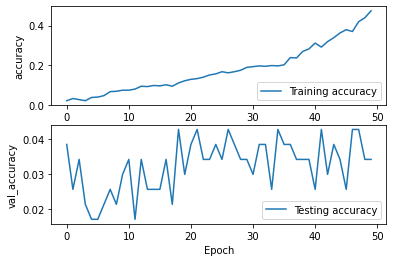

In [37]:
plot_history(history)